# Final Modeling for Presentation

Katie O'Connor, Kim Buesser, Kyle Anderson, Grif Brown

# Overview

- Introduce Monza and rotary can line
- Show the time series graph of canline (the single blue line graph) to explain that we've identified the trend before 2023 as normal, and after 2023 as non-normal - we're essentially identifying this as an anomoly
  - Show prophet model including 2023 to show the anomoly
- Show the pearson correlation graph w/ quick explanation of how we're jumping from can line to equipment
- Transition into equipment time series graphs (can show all 3 or just 1)
- Identify that there's an anomoly present in the time series graph in 2023
- Transition into last two graphs on maintenance time in minutes vs the count of maintenance activities
-
- finish off with Grif's dashboard madness

## Import Packages
### Prep Colab Notebook

In [5]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.cloud import storage
import os
from io import StringIO
import json
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.metrics import mean_squared_error, r2_score
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read in File and Prepare for Cleaning

In [7]:
warnings.filterwarnings('ignore')
# data upload
file_path = '/content/drive/MyDrive/Colab Notebooks/IWC_Work_Orders_Extract.csv'
df = pd.read_csv(file_path)


# Identify and convert any date columns based on their names
date_columns = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Filter data to include only entries from 2017 onwards
df = df[df['EXECUTION_START_DATE'] >= '2017-01-01']

In [8]:
df['EXECUTION_START_DATE'] = pd.to_datetime(df['EXECUTION_START_DATE'])
df['Month'] = df['EXECUTION_START_DATE'].dt.to_period('M').dt.to_timestamp()
df['Week'] = df['EXECUTION_START_DATE'].dt.to_period('W').dt.to_timestamp()
df = df[df['PRODUCTION_LOCATION'] == 'MONZA']
df.groupby('FUNCTIONAL_AREA_NODE_2_MODIFIED')['PRODUCTION_LOCATION'].count().sort_values(ascending=False)

FUNCTIONAL_AREA_NODE_2_MODIFIED
BTL_PET_LINE                       32789
ROTARY_CAN_LINE                    14016
WATER TREATMENT                     2474
AIR SYSTEMS                         2315
WASTE WATER TREATMENT               1070
AMMONIA & REFRIGERATION SYSTEMS      835
RECYCLING                            755
NITROGEN SYSTEMS                     446
SHOP / REPAIR AREA                   393
CO2 SYSTEMS                          305
SYRUP/BLENDING ROOM                  290
QUALITY ASSURANCE EQUIPMENT          275
SAFETY EQUIPMENT                     187
WAREHOUSE1                           164
MOBILE EQUIPMENT                     155
PRODUCTION                           146
LOADING DOCKS                         94
STEAM SYSTEMS                         85
SANITATION                            59
LUBE CAGE                             49
OFFICES                               48
ELECTRICAL SYSTEMS                    14
CHEMICAL ROOM                         14
LIS SYSTEM                             1
Name: PRODUCTION_LOCATION, dtype: int64

# Minutes for Unplanned and Planned Maintenance

In [9]:
og_minutes = df[['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC', 'ACTUAL_WORK_IN_MINUTES','MAINTENANCE_ACTIVITY_TYPE']]

In [10]:
equipment_names = ['L3 FILLER_ROTARY_BTL_100_VALVE', 'L2 FILLER_ROTARY_BTL_45_VALVE', 'L4 FILLER_ROTARY_CAN_100_VALVE']
og_minutes = og_minutes[og_minutes['EQUIPMENT_DESC'].isin(equipment_names)]

In [11]:
original_total_minutes = og_minutes['ACTUAL_WORK_IN_MINUTES'].sum()
original_planned = og_minutes[og_minutes['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned']
original_unplanned =  og_minutes[og_minutes['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']
original_planned = original_planned['ACTUAL_WORK_IN_MINUTES'].sum()
original_unplanned = original_unplanned['ACTUAL_WORK_IN_MINUTES'].sum()

print("Original Total Minutes:", original_total_minutes)
print("Planned Minutes:", round(original_planned,0))
print("Unplanned Minutes:", round(original_unplanned,0))

extra_unplanned_time = 100-(((original_unplanned - original_planned)/ original_unplanned)*100)
print(round(extra_unplanned_time,0),'% More Time Spent on Unplanned Maintenance')

Original Total Minutes: 657286.8
Planned Minutes: 166254.0
Unplanned Minutes: 491033.0
34.0 % More Time Spent on Unplanned Maintenance


34% More Time Spent on Unplanned Maintenance

## Aggregating Job, Maintenance Type and Minutes Spent

In [12]:
# Separate DataFrames for planned and unplanned maintenance
planned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned']
unplanned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Group and calculate aggregates for planned maintenance
planned_agg = planned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_planned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_planned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Group and calculate aggregates for unplanned maintenance
unplanned_agg = unplanned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_unplanned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_unplanned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge the two aggregated DataFrames on the common columns
agg_df = pd.merge(planned_agg, unplanned_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Calculate overall average minutes and count from the original DataFrame
overall_agg = df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge with the overall data
agg_df = pd.merge(agg_df, overall_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Filter the final DataFrame based on conditions
agg_df['time_saved'] = (agg_df['average_minutes_unplanned'] - agg_df['average_minutes_planned']).fillna(0)

agg_df['ratio_jobs'] = agg_df['count_planned'] / agg_df['count']

agg_df['ratio_minutes'] = agg_df['average_minutes_planned'] / agg_df['average_minutes_unplanned']

planned_vs_unplanned_key = agg_df

In [13]:
grouped_data = df.groupby(['EQUIPMENT_DESC'])['MAINTENANCE_ACTIVITY_TYPE'].count()
# Reset the index to convert the result to a DataFrame
grouped_data = grouped_data.reset_index()

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

df_for_list = grouped_data[grouped_data['Activity_Count']> 500]
equipment_list = df_for_list['EQUIPMENT_DESC'].tolist()

In [14]:
planned_vs_unplanned_key[
    planned_vs_unplanned_key['EQUIPMENT_DESC'].isin(equipment_list)
].sort_values(by='time_saved', ascending=False)

PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  \
292               MONZA                 ROTARY_CAN_LINE   
134               MONZA                    BTL_PET_LINE   
296               MONZA                 ROTARY_CAN_LINE   
141               MONZA                    BTL_PET_LINE   
109               MONZA                    BTL_PET_LINE   
110               MONZA                    BTL_PET_LINE   
88                MONZA                    BTL_PET_LINE   
164               MONZA                    BTL_PET_LINE   
160               MONZA                    BTL_PET_LINE   
132               MONZA                    BTL_PET_LINE   
139               MONZA                    BTL_PET_LINE   
85                MONZA                    BTL_PET_LINE   
303               MONZA                 ROTARY_CAN_LINE   
105               MONZA                    BTL_PET_LINE   
91                MONZA                    BTL_PET_LINE   
300               MONZA                 ROTARY_CAN_LINE   
162               MONZA                    BTL_PET_LINE   
103               MONZA                    BTL_PET_LINE   
163               MONZA                    BTL_PET_LINE   
286               MONZA                 ROTARY_CAN_LINE   
159               MONZA                    BTL_PET_LINE   
106               MONZA                    BTL_PET_LINE   
0                 MONZA                     AIR SYSTEMS   
3                 MONZA                     AIR SYSTEMS   

                     EQUIPMENT_DESC  average_minutes_planned  count_planned  \
292  L4 FILLER_ROTARY_CAN_100_VALVE                23.188340         2024.0   
134  L3 FILLER_ROTARY_BTL_100_VALVE                52.906592          895.0   
296                  L4 PACKER_CASE                25.624484         1405.0   
141            L3 PACKER KHS TSP80V                36.601443         1247.0   
109        L2 PALLETIZER_LINE 2_PAI                37.870318          785.0   
110    L2 RINSER_ROTARY_SIMPLIMATIC                29.635669          471.0   
88    L1 FILLER_ROTARY_BTL_60_VALVE                25.338889         1944.0   
164         LINE 1 RINSER_LOWERATOR                26.702304          651.0   
160           LINE 1 LABELER_ROTARY                30.635633         1145.0   
132          L3 DEPAL_ELECPNEU_ CAN                46.711111          675.0   
139               L3 LABELER_ROTARY                29.700868         1729.0   
85                   L1 CAPPER_RTRY                32.742439         1230.0   
303                 L4 WARMER_SPRAY                33.417447          470.0   
105   L2 FILLER_ROTARY_BTL_45_VALVE                69.941108         1029.0   
91               L2 CAPPER_RTRY_9HD                39.063817         1006.0   
300                L4 SEAMER_ROTARY                26.401377         1743.0   
162              LINE 1 PACKER_TRAY               114.367521          351.0   
103        L2 DEPAL_ELECPNEU_BOTTLE                31.394979          717.0   
163             LINE 1 RINSER_IONIC                26.550186          807.0   
286          L4 DEPAL_ELECPNEU_ CAN                37.727771          839.0   
159           LINE 1 DEPAL_ELECPNEU                52.975771          454.0   
106               L2 LABELER_ROTARY                48.756989          558.0   
0                    COMP_SCREW_AIR                26.658577          717.0   
3                  DRYER_AIR_REFRIG                19.649687          958.0   

     average_minutes_unplanned  count_unplanned  average_minutes  count  \
292                 311.488706            487.0        79.103226   2511   
134                 297.660104            579.0       149.047897   1474   
296                 259.056140            171.0        50.952411   1576   
141                 192.797232            289.0        65.989844   1536   
109                 191.067722            316.0        81.839782   1101   
110                 166.150000             48.0        42.261272    519   
88                  160.797

## Prophet Modeling by Week for Rotary Can

COMP_SCREW_AIR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/lrdxs0tf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/myiq46fa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65864', 'data', 'file=/tmp/tmp8ovekdqu/lrdxs0tf.json', 'init=/tmp/tmp8ovekdqu/myiq46fa.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelts9_cp4g/prophet_model-20241125233808.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:08 - cmdstanpy - INFO - Chai

Mean Squared Error (MSE): 5362.530452862069
R-squared: 0.14862979459051395


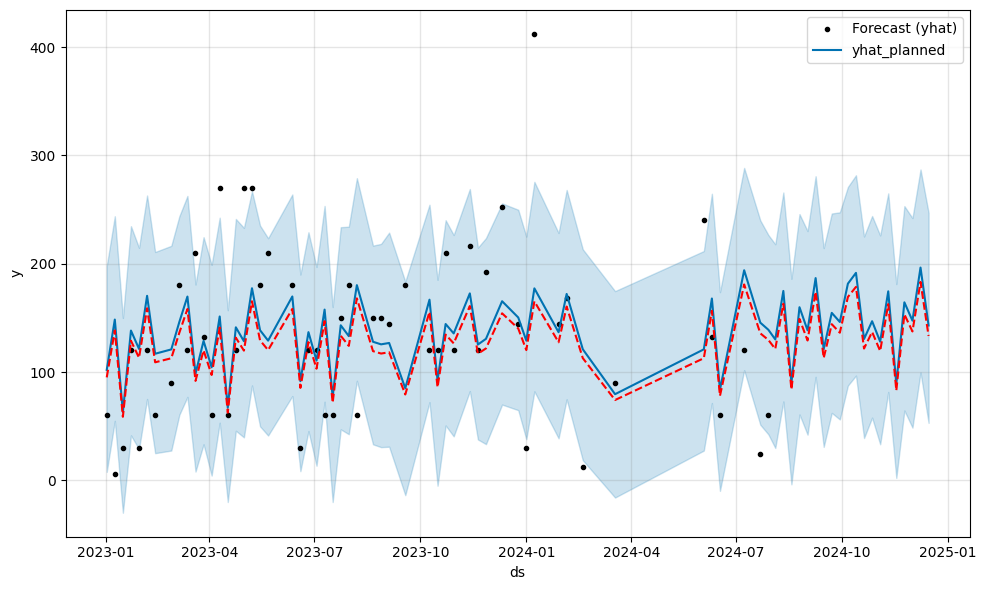

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1slrgcu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/uzkh1yih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95187', 'data', 'file=/tmp/tmp8ovekdqu/1slrgcu3.json', 'init=/tmp/tmp8ovekdqu/uzkh1yih.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelhtnthk66/prophet_model-20241125233809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


DRYER_AIR_REFRIG


23:38:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 1993.4153043590525
R-squared: 0.2552272349303827


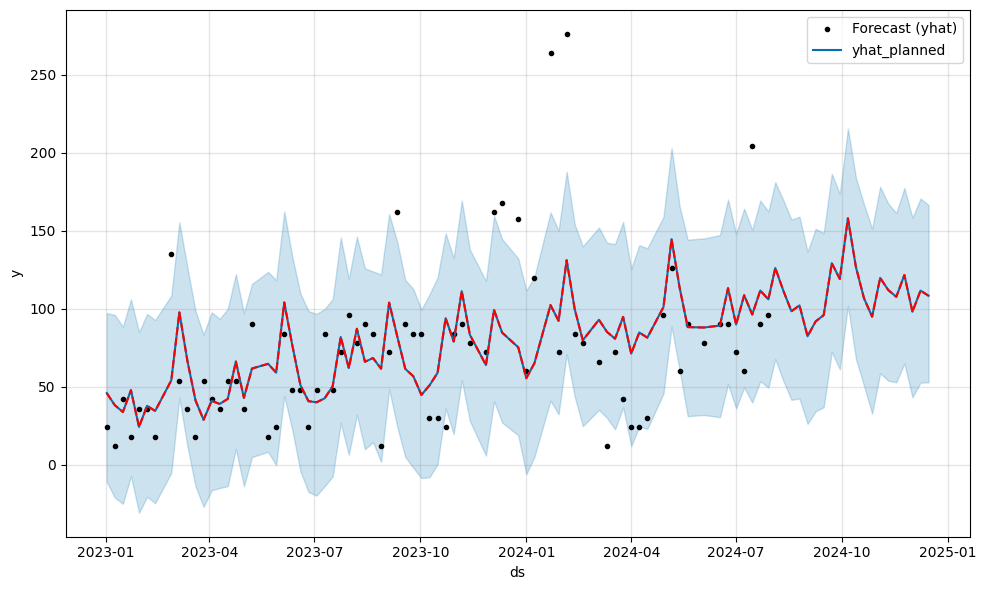

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/st1841en.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/791fpgti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53467', 'data', 'file=/tmp/tmp8ovekdqu/st1841en.json', 'init=/tmp/tmp8ovekdqu/791fpgti.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelae8aluwb/prophet_model-20241125233809.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L1 CAPPER_RTRY


23:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 114335.67244852484
R-squared: 0.05280928870860668


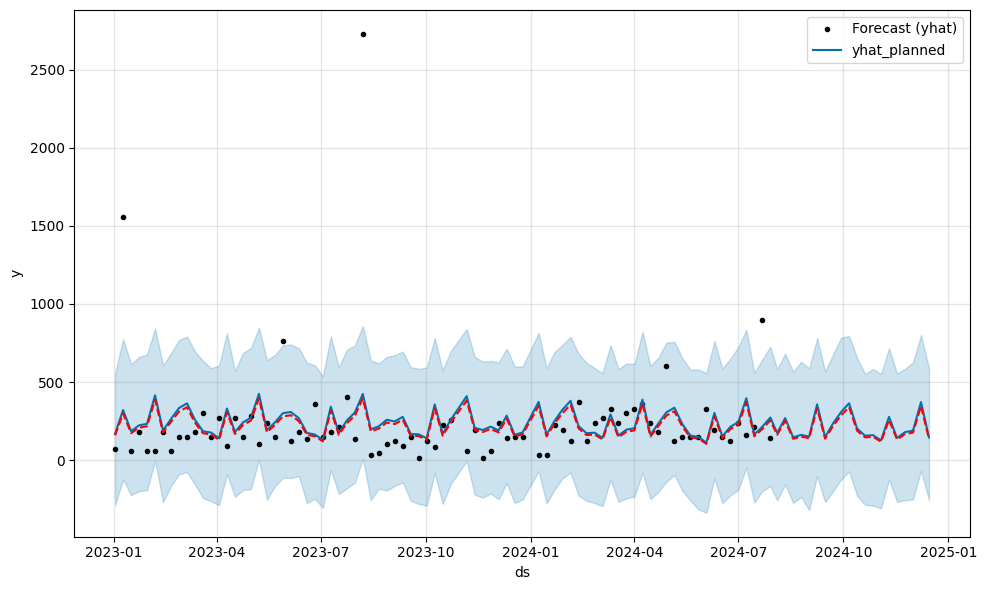

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/2nsepy1f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/6g3fvfcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85934', 'data', 'file=/tmp/tmp8ovekdqu/2nsepy1f.json', 'init=/tmp/tmp8ovekdqu/6g3fvfcl.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model40xx24d0/prophet_model-20241125233810.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L1 FILLER_ROTARY_BTL_60_VALVE


23:38:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 411913.4190688294
R-squared: 0.18474949054458478


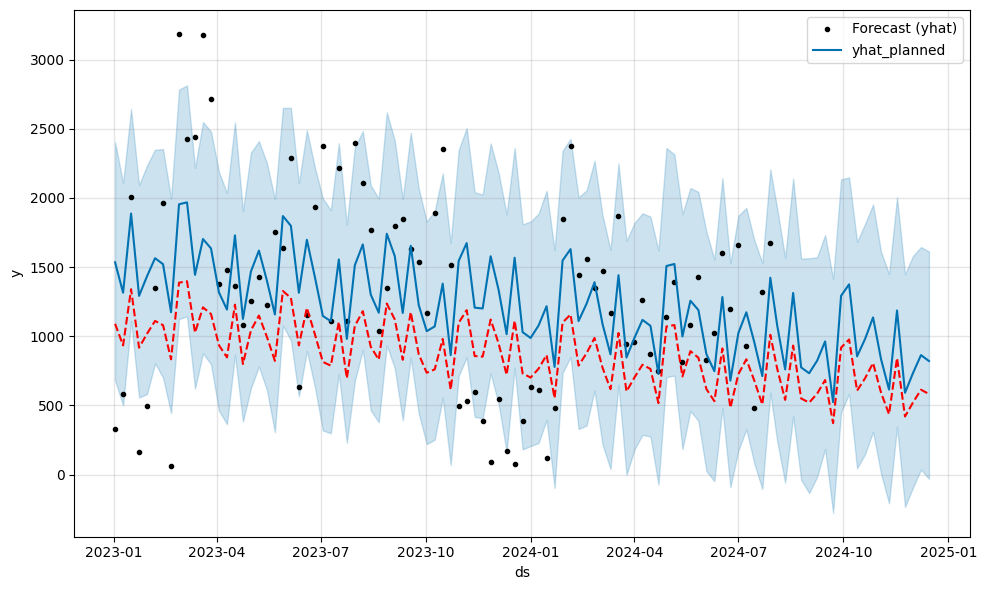

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


L2 CAPPER_RTRY_9HD


INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1d6xxbir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/x_ksbico.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69590', 'data', 'file=/tmp/tmp8ovekdqu/1d6xxbir.json', 'init=/tmp/tmp8ovekdqu/x_ksbico.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modellem0h47a/prophet_model-20241125233811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 7430.645904369245
R-squared: 0.6315663126867115


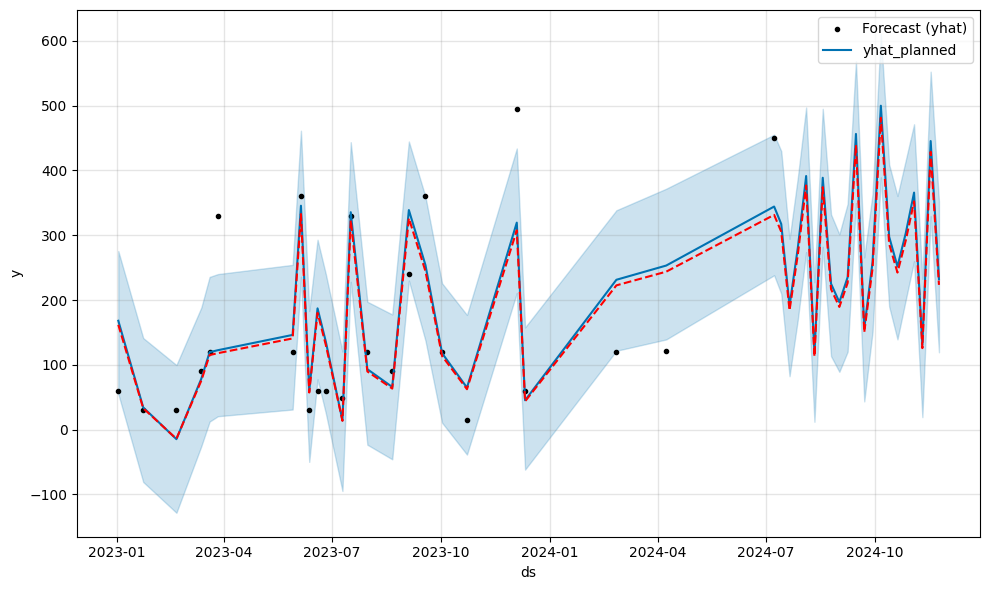

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/jk7ogt_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/l4ych098.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51815', 'data', 'file=/tmp/tmp8ovekdqu/jk7ogt_u.json', 'init=/tmp/tmp8ovekdqu/l4ych098.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelk_wyzush/prophet_model-20241125233812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 DEPAL_ELECPNEU_BOTTLE


23:38:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 8653.068043035202
R-squared: 0.16298961206180385


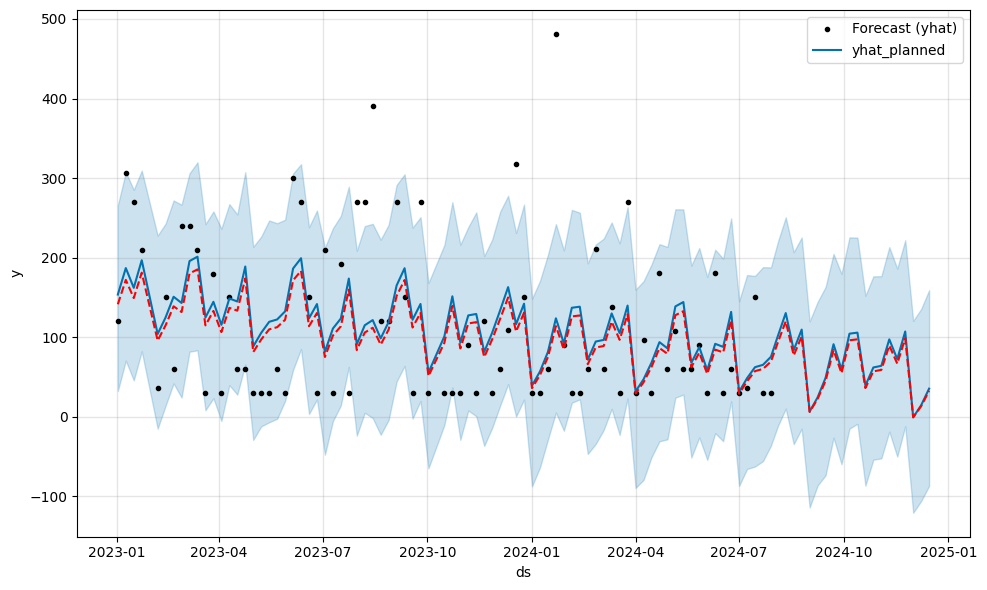

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/2d3kcbns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/xa_kh0xp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57772', 'data', 'file=/tmp/tmp8ovekdqu/2d3kcbns.json', 'init=/tmp/tmp8ovekdqu/xa_kh0xp.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelwxeyjrc1/prophet_model-20241125233812.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 FILLER_ROTARY_BTL_45_VALVE


23:38:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 746924.6208877681
R-squared: 0.053881169655703665


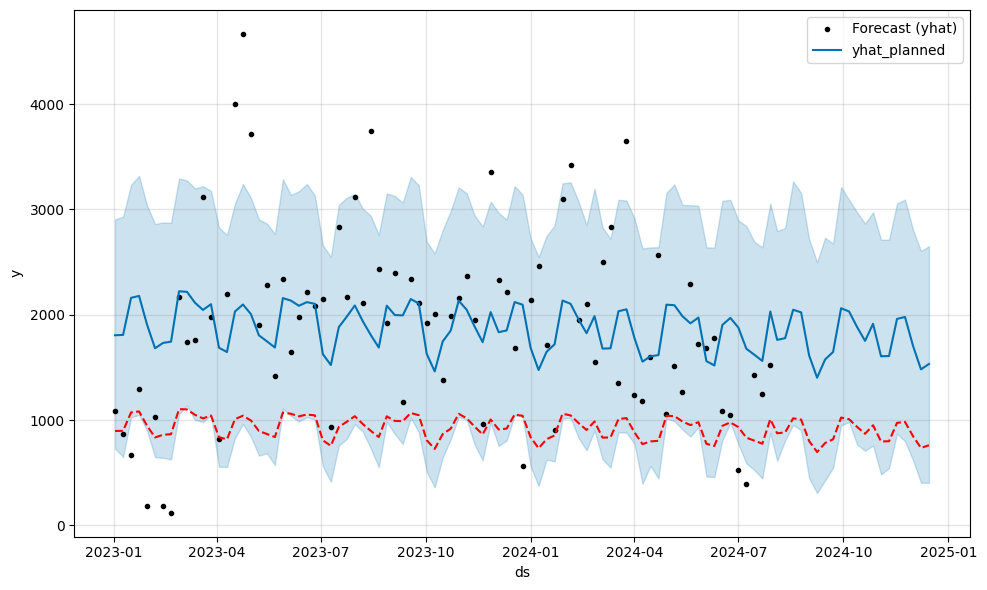

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7tqsm1v0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/f1w6hgms.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35774', 'data', 'file=/tmp/tmp8ovekdqu/7tqsm1v0.json', 'init=/tmp/tmp8ovekdqu/f1w6hgms.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelubiwowih/prophet_model-20241125233814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 LABELER_ROTARY


23:38:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 7070.335890173189
R-squared: 0.2120515117747933


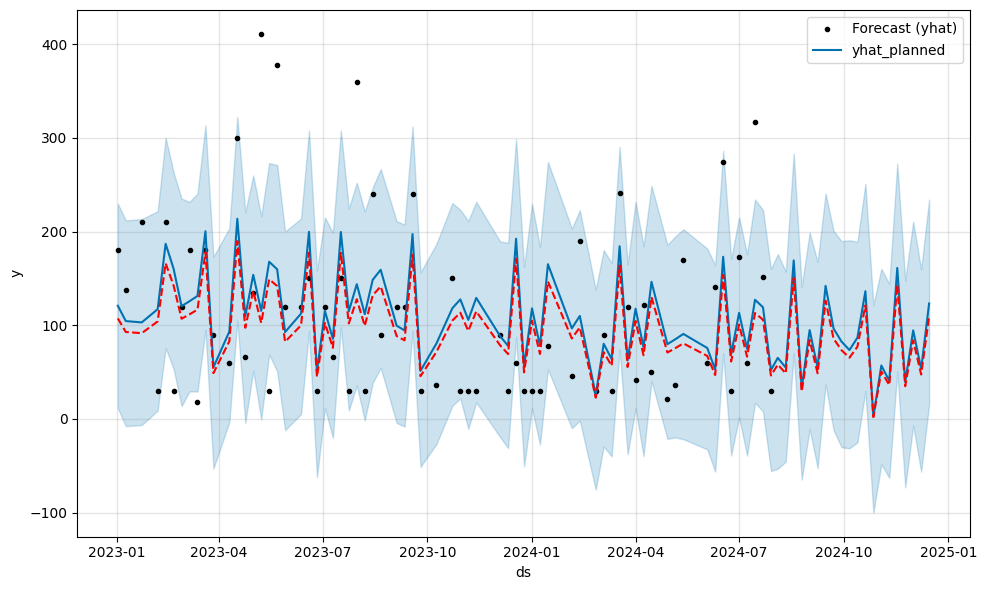

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/mlfi0h_6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/360r2mb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97927', 'data', 'file=/tmp/tmp8ovekdqu/mlfi0h_6.json', 'init=/tmp/tmp8ovekdqu/360r2mb6.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelc0nhefda/prophet_model-20241125233815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 PALLETIZER_LINE 2_PAI


23:38:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 118438.85460725013
R-squared: 0.1431093349010114


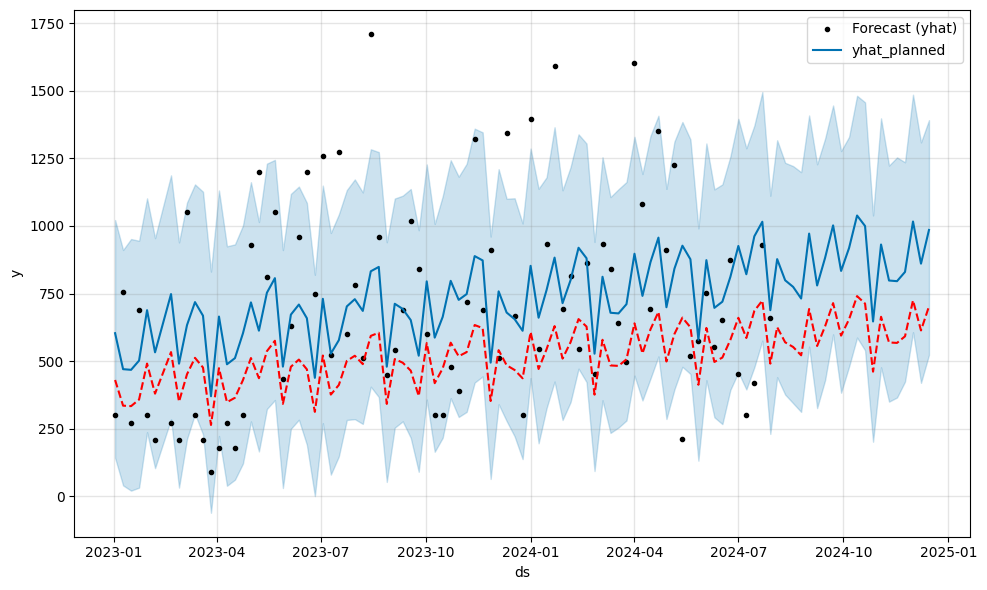

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vlgl842u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/0dh7j5tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98259', 'data', 'file=/tmp/tmp8ovekdqu/vlgl842u.json', 'init=/tmp/tmp8ovekdqu/0dh7j5tg.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelvbv2uqm4/prophet_model-20241125233816.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 RINSER_ROTARY_SIMPLIMATIC


23:38:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 98251.24480139848
R-squared: 0.2482422046402678


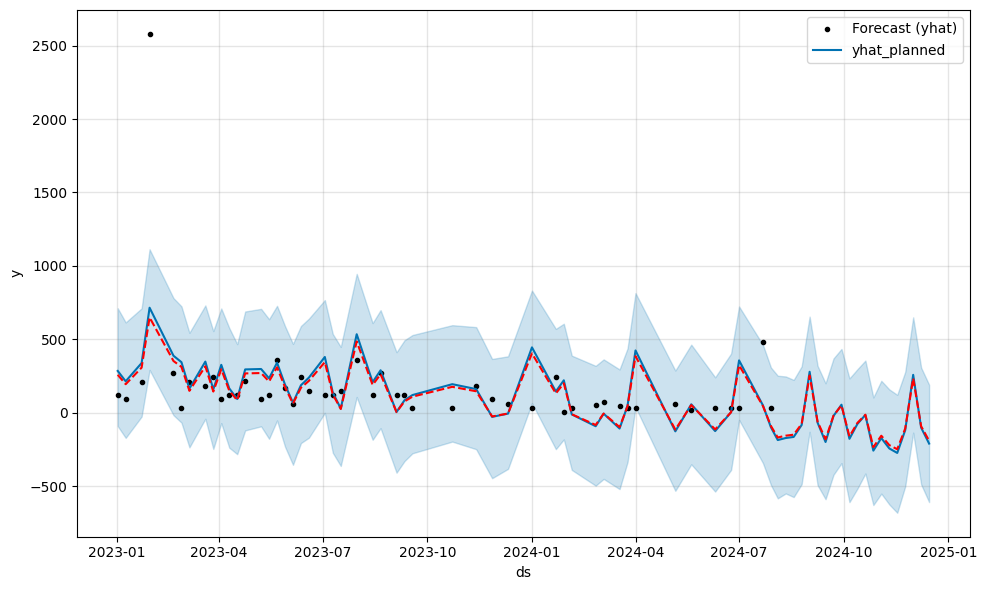

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7fckikmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vp0f9zcr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22976', 'data', 'file=/tmp/tmp8ovekdqu/7fckikmd.json', 'init=/tmp/tmp8ovekdqu/vp0f9zcr.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelsa2j8j45/prophet_model-20241125233817.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 DEPAL_ELECPNEU_ CAN


23:38:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 296836.53361258167
R-squared: 0.1449386226244671


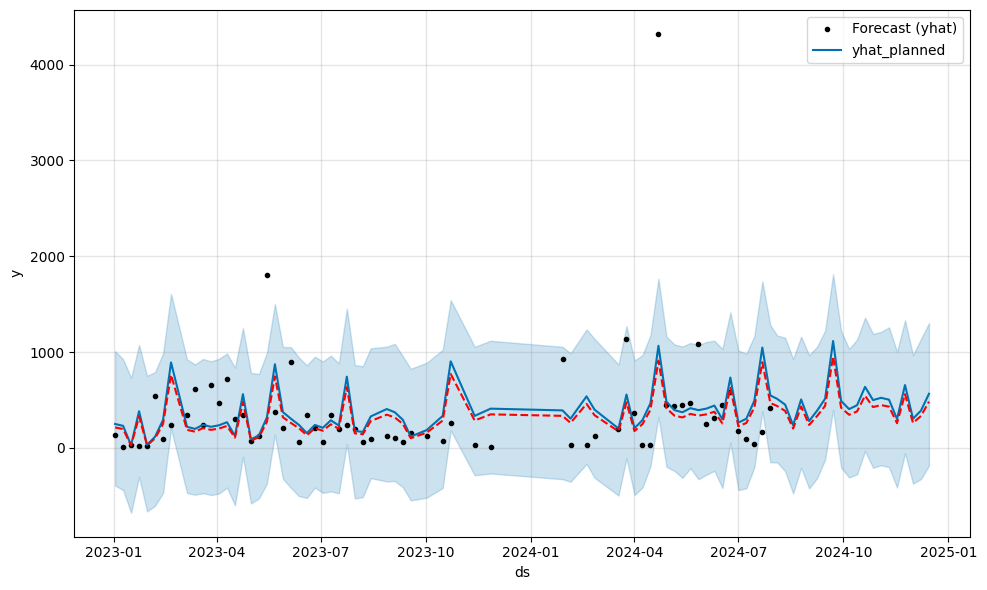

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/m2mpsqx6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7vz_x4rl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9694', 'data', 'file=/tmp/tmp8ovekdqu/m2mpsqx6.json', 'init=/tmp/tmp8ovekdqu/7vz_x4rl.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modeldp9bsb6g/prophet_model-20241125233818.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 FILLER_ROTARY_BTL_100_VALVE


23:38:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491


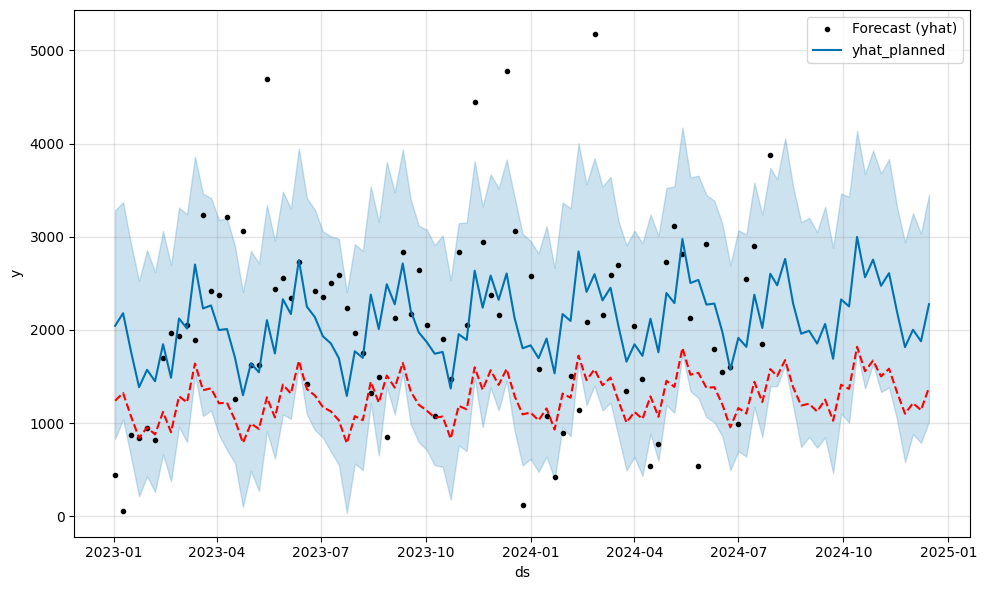

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/qe4r6f5b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/sanrmhwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84669', 'data', 'file=/tmp/tmp8ovekdqu/qe4r6f5b.json', 'init=/tmp/tmp8ovekdqu/sanrmhwj.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modeli8_7xg35/prophet_model-20241125233819.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 LABELER_ROTARY


23:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 173774.39138557896
R-squared: 0.22080460350779663


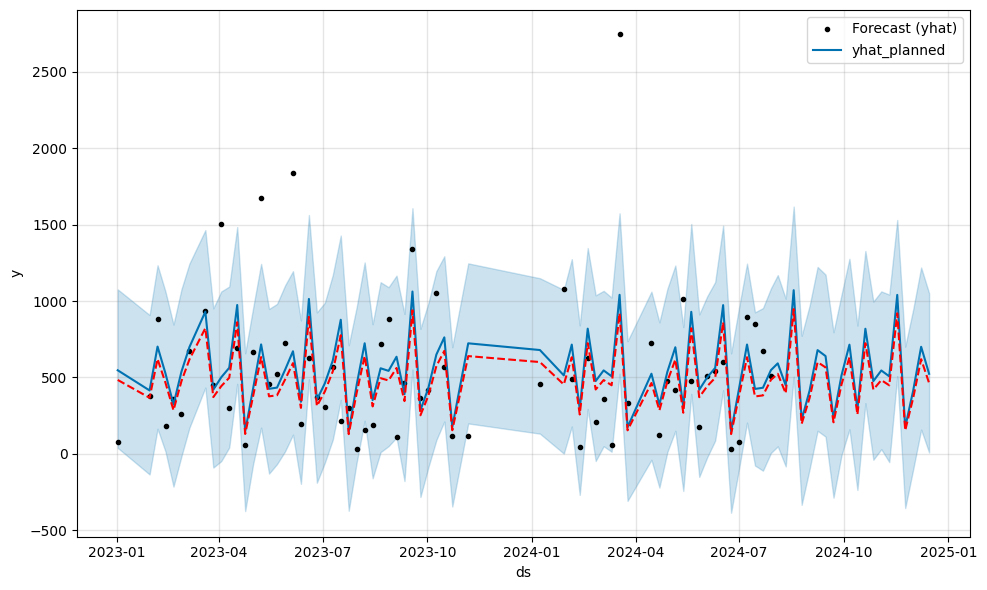

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ga7fvti7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/3cl8lzj9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31721', 'data', 'file=/tmp/tmp8ovekdqu/ga7fvti7.json', 'init=/tmp/tmp8ovekdqu/3cl8lzj9.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelogfix_g1/prophet_model-20241125233820.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 PACKER KHS TSP80V


23:38:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 424312.22463569086
R-squared: 0.09809272844146943


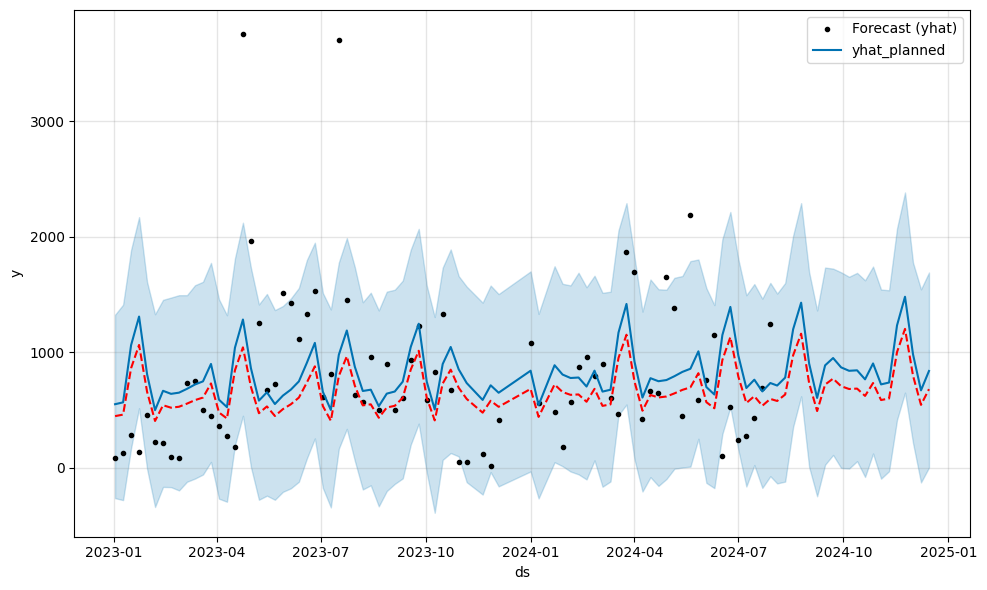

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/8o5enlw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/kr8xiwx4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74490', 'data', 'file=/tmp/tmp8ovekdqu/8o5enlw6.json', 'init=/tmp/tmp8ovekdqu/kr8xiwx4.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model_fp0q7nw/prophet_model-20241125233821.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 DEPAL_ELECPNEU_ CAN


23:38:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 30673.445410892033
R-squared: 0.17919200858347462


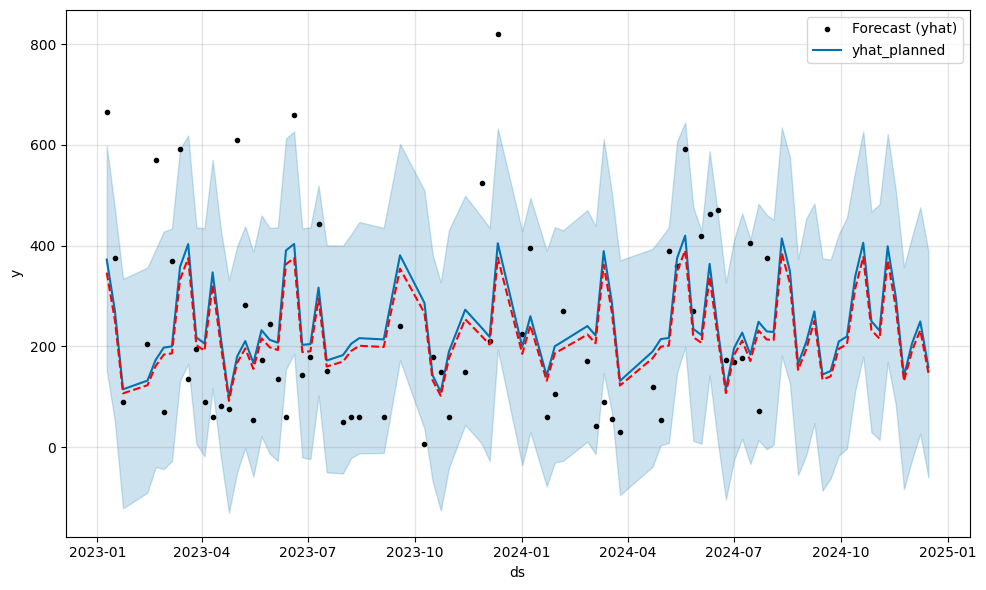

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/75pzdw5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/n80dxswv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97585', 'data', 'file=/tmp/tmp8ovekdqu/75pzdw5v.json', 'init=/tmp/tmp8ovekdqu/n80dxswv.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model699uai_e/prophet_model-20241125233822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 FILLER_ROTARY_CAN_100_VALVE


23:38:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 587406.7940249428
R-squared: 0.2155564305464549


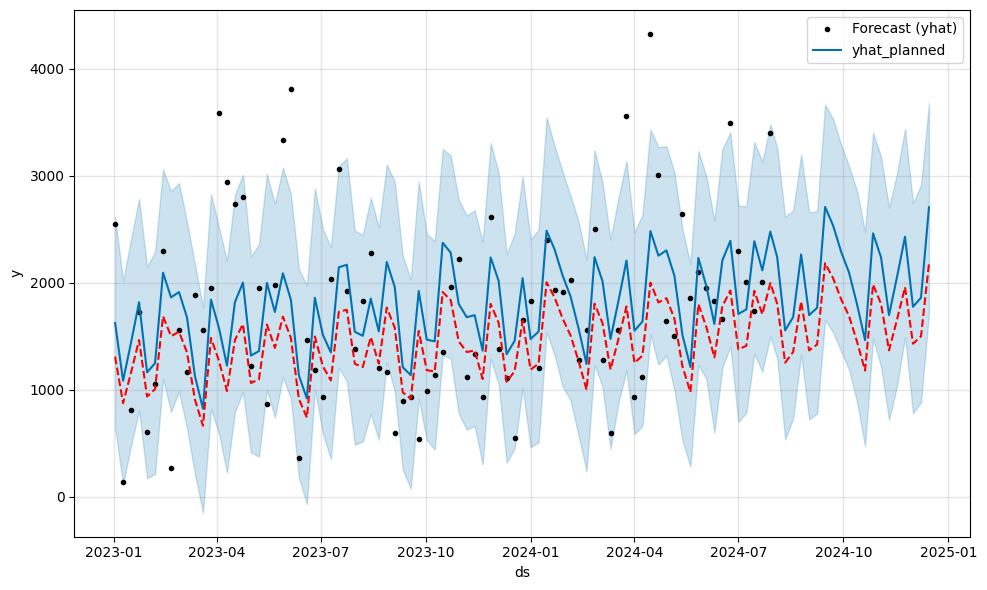

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/j_1j6xke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/zhqkv35l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85826', 'data', 'file=/tmp/tmp8ovekdqu/j_1j6xke.json', 'init=/tmp/tmp8ovekdqu/zhqkv35l.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model7n_hue4w/prophet_model-20241125233822.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 PACKER_CASE


23:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 470788.5941733852
R-squared: 0.27988775227336515


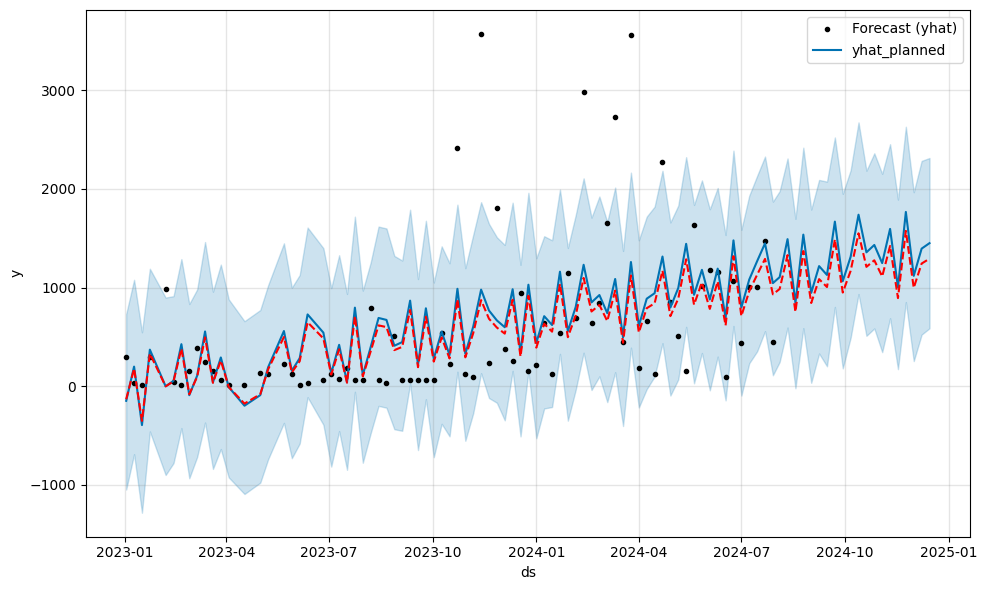

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/52xe5xqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vnfa582e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45337', 'data', 'file=/tmp/tmp8ovekdqu/52xe5xqr.json', 'init=/tmp/tmp8ovekdqu/vnfa582e.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model3xqw9n7b/prophet_model-20241125233823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 SEAMER_ROTARY


23:38:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 43876.34785699708
R-squared: 0.10964954721412745


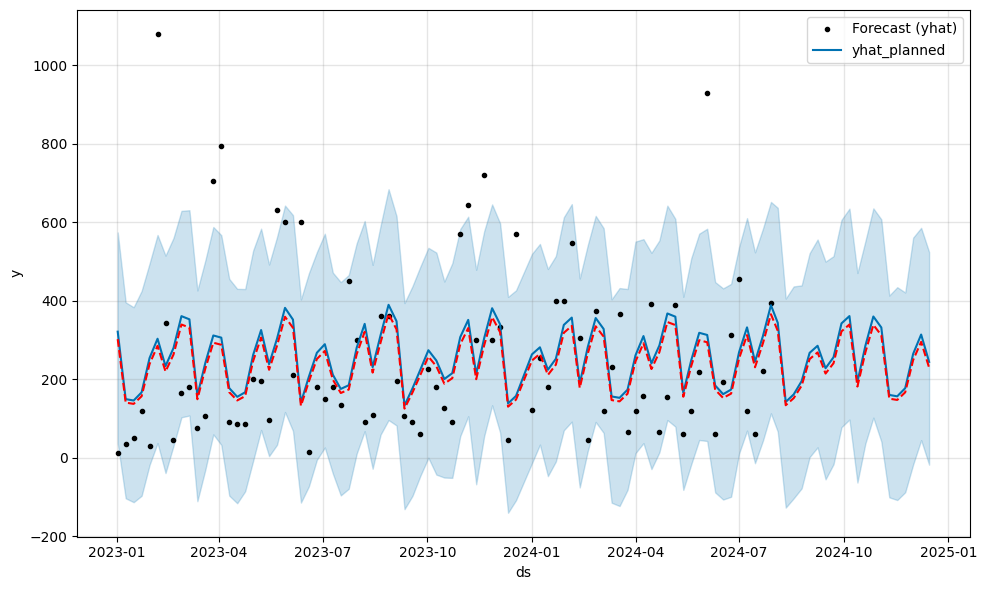

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7uzbz1s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/6wqhg9p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93558', 'data', 'file=/tmp/tmp8ovekdqu/7uzbz1s7.json', 'init=/tmp/tmp8ovekdqu/6wqhg9p9.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelq963o09t/prophet_model-20241125233824.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 WARMER_SPRAY


23:38:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 128686.65728778655
R-squared: 0.1692370394312558


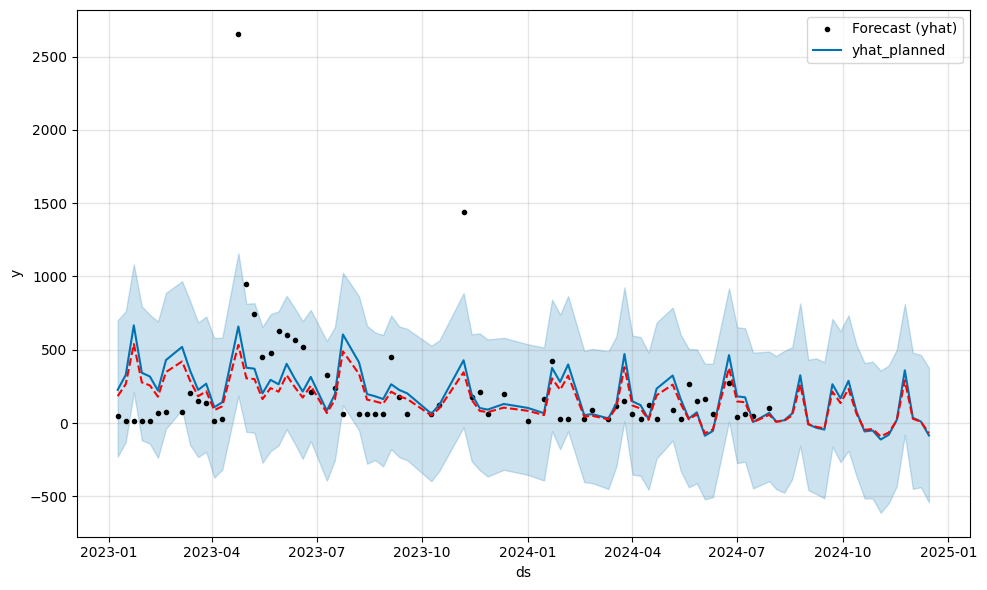

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/0i96reyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/oodz5kkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54159', 'data', 'file=/tmp/tmp8ovekdqu/0i96reyd.json', 'init=/tmp/tmp8ovekdqu/oodz5kkl.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelkwlws_7a/prophet_model-20241125233825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


LINE 1 DEPAL_ELECPNEU


23:38:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 25780.80113670328
R-squared: 0.21692510284497868


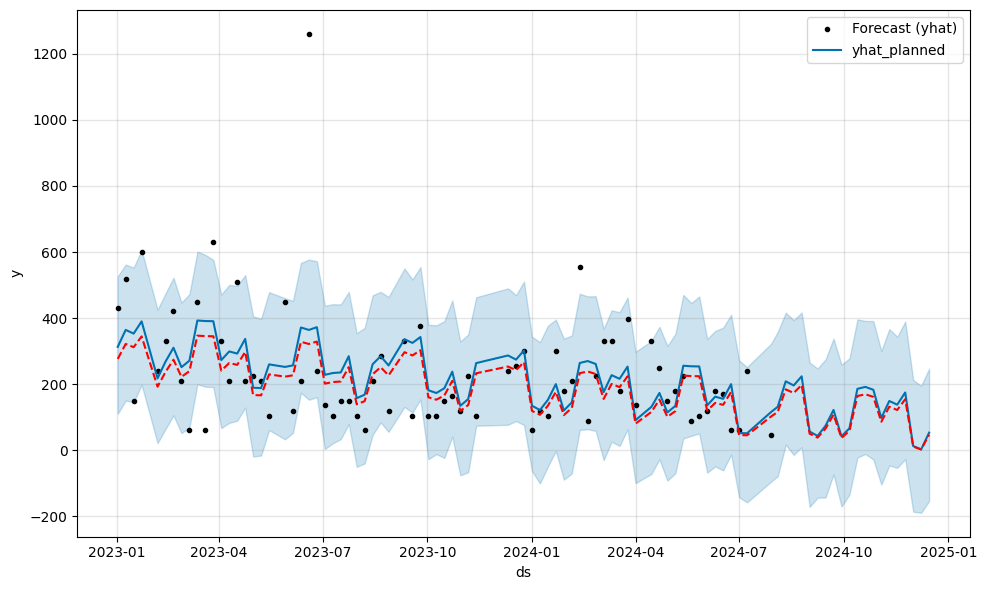

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/839p8nes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vjtxakbh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=559', 'data', 'file=/tmp/tmp8ovekdqu/839p8nes.json', 'init=/tmp/tmp8ovekdqu/vjtxakbh.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelvqjigc4h/prophet_model-20241125233826.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


LINE 1 LABELER_ROTARY


23:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 209678.0706568995
R-squared: 0.22404795454195248


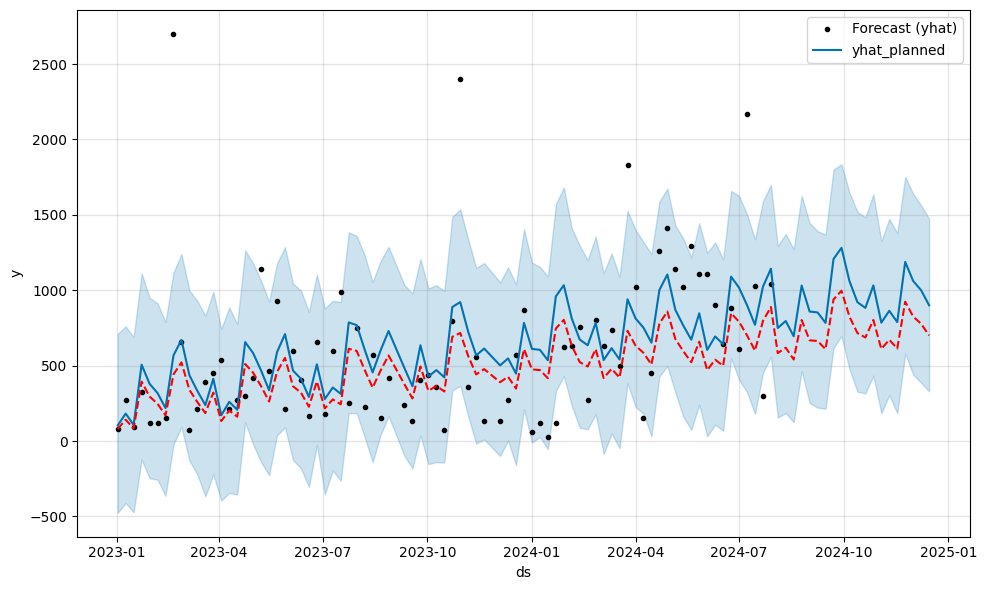

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/0wj_6h3t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/2rkcwmx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48105', 'data', 'file=/tmp/tmp8ovekdqu/0wj_6h3t.json', 'init=/tmp/tmp8ovekdqu/2rkcwmx9.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelk070znw4/prophet_model-20241125233827.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


LINE 1 PACKER_TRAY


23:38:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 158772.34954873315
R-squared: 0.2402081490061716


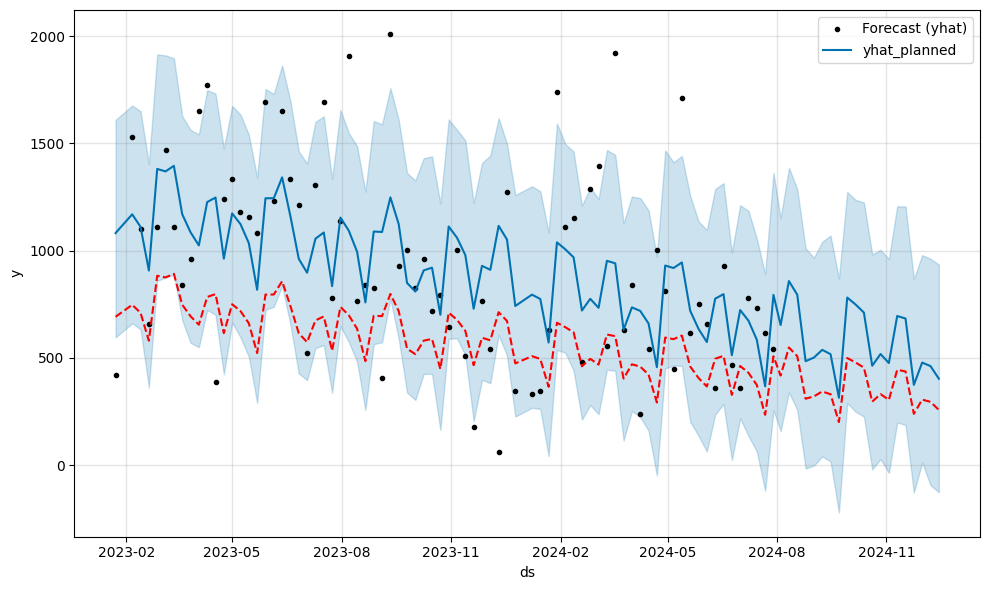

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/5540byti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/o47mjkzj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78426', 'data', 'file=/tmp/tmp8ovekdqu/5540byti.json', 'init=/tmp/tmp8ovekdqu/o47mjkzj.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelli01i3_p/prophet_model-20241125233828.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


LINE 1 RINSER_IONIC


23:38:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 16057.49200863156
R-squared: 0.1786726899702762


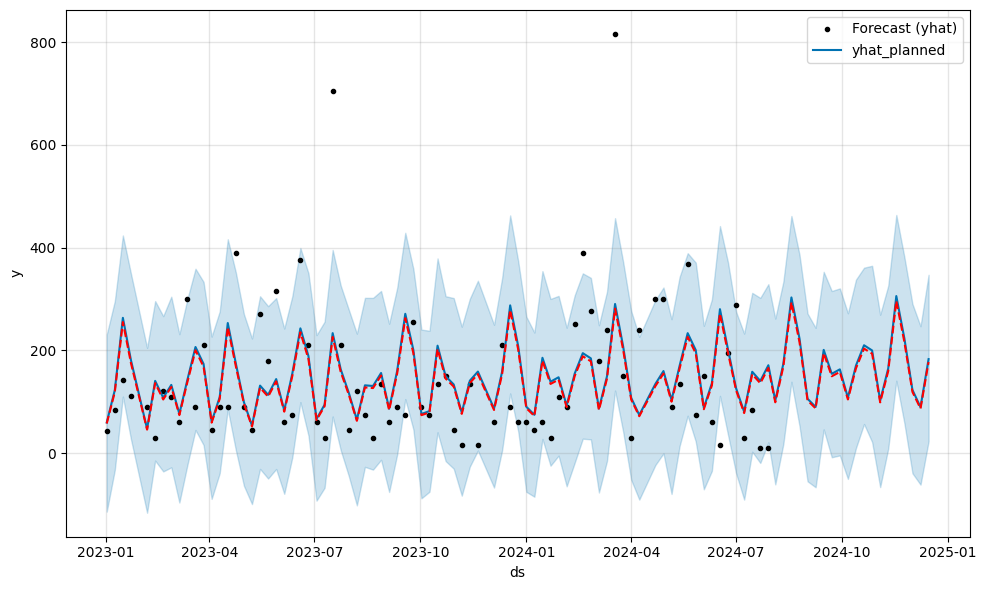

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vbck8we_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/_8teo5dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39122', 'data', 'file=/tmp/tmp8ovekdqu/vbck8we_.json', 'init=/tmp/tmp8ovekdqu/_8teo5dw.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelxqk2chx6/prophet_model-20241125233829.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


LINE 1 RINSER_LOWERATOR


23:38:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874


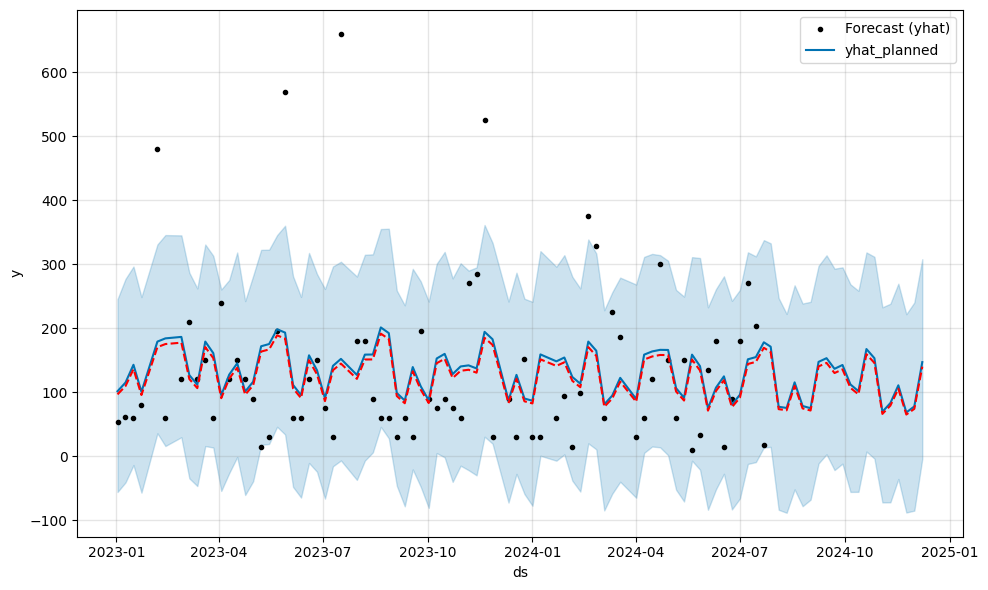

In [15]:
for equipment in equipment_list:
  print(equipment)
  rotary_can_ts = df[
      (df['EQUIPMENT_DESC'] == equipment) &
      (df['Week'] > '2023-01-01') &
      (df['Week'] < '2024-08-01')
  ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
  rotary_can_ts = rotary_can_ts.reset_index()

  rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

  # Prepare the data for Prophet
  prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

  # Fit the Prophet model
  # model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
  # model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  # model = Prophet()
  model = Prophet()
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(prophet_data)

  # Make a future DataFrame for predictions (for the next 12 months)
  future = model.make_future_dataframe(periods=20, freq='W')

  # Make predictions
  forecast = model.predict(future)

  # Evaluate the model
  # Align the predictions with actual data
  predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
  actual = rotary_can_ts.set_index('Week')

  ratio_jobs = planned_vs_unplanned_key.loc[
      planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
  ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

  forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs

  # Calculate performance metrics
  mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
  r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

  # Output results
  print("Mean Squared Error (MSE):", mse)
  print("R-squared:", r2)

  # Plot the forecast
  # Plot the forecast with yhat_planned
  fig = model.plot(forecast)
  ax = fig.gca()  # Get the current axes
  ax.plot(forecast['ds'], forecast['yhat_planned'], label='yhat_planned', color='red', linestyle='--')
  ax.legend(['Forecast (yhat)', 'yhat_planned'])
  plt.show()

In [16]:
## Pro

## Prophet Model by Week by Rotary Can

In [17]:
# Initialize an empty list to store DataFrames
all_results = []

for equipment in equipment_list:
    print(equipment)
    rotary_can_ts = df[
        (df['EQUIPMENT_DESC'] == equipment) &
        (df['Week'] > '2023-01-01') &
        (df['Week'] < '2024-08-01')
    ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
    rotary_can_ts = rotary_can_ts.reset_index()

    rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

    # Prepare the data for Prophet
    prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_data)

    # Make a future DataFrame for predictions (for the next 12 months)
    future = model.make_future_dataframe(periods=20, freq='W')

    # Make predictions
    forecast = model.predict(future)

    # Align the predictions with actual data
    predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
    actual = rotary_can_ts.set_index('Week')

    ratio_jobs = planned_vs_unplanned_key.loc[
        planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
    ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

    forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs

    # Output results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)

    # Add a description column
    forecast['description'] = equipment
    forecast['original_y'] = pd.merge(forecast, prophet_data, on='ds', how='left')['y']

    # Append the result to the list
    all_results.append(forecast)

# Concatenate all the results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/cjoox_ht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/w428p9gv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24781', 'data', 'file=/tmp/tmp8ovekdqu/cjoox_ht.json', 'init=/tmp/tmp8ovekdqu/w428p9gv.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model6gqdr9kj/prophet_model-20241125233830.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


COMP_SCREW_AIR


23:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/h1tghm_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/dezqqxl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96176', 'data', 'file=/tmp/tmp8ovekdqu/h1tghm_x.json', 'init=/tmp/tmp8ovekdqu/dezqqxl4.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model7sthozbu/prophet_model-20241125233831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:31 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
DRYER_AIR_REFRIG


23:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/p1ohrooe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/4kmdaduh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57190', 'data', 'file=/tmp/tmp8ovekdqu/p1ohrooe.json', 'init=/tmp/tmp8ovekdqu/4kmdaduh.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model_4uaptr8/prophet_model-20241125233831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:31 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L1 CAPPER_RTRY


23:38:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/f5hfgs3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/are__u1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31560', 'data', 'file=/tmp/tmp8ovekdqu/f5hfgs3i.json', 'init=/tmp/tmp8ovekdqu/are__u1j.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelyroos0vh/prophet_model-20241125233831.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:31 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L1 FILLER_ROTARY_BTL_60_VALVE


23:38:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/tl8kldrl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/n1i23tez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39720', 'data', 'file=/tmp/tmp8ovekdqu/tl8kldrl.json', 'init=/tmp/tmp8ovekdqu/n1i23tez.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelkhsw44w6/prophet_model-20241125233832.csv', 'method=optimi

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 CAPPER_RTRY_9HD


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/pgr3n_ef.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/gnlualiw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86952', 'data', 'file=/tmp/tmp8ovekdqu/pgr3n_ef.json', 'init=/tmp/tmp8ovekdqu/gnlualiw.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelwbv62iqt/prophet_model-20241125233832.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 DEPAL_ELECPNEU_BOTTLE


23:38:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/nh_hdxrj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ua1icbwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24967', 'data', 'file=/tmp/tmp8ovekdqu/nh_hdxrj.json', 'init=/tmp/tmp8ovekdqu/ua1icbwy.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelr1y5grm2/prophet_model-20241125233833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:33 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 FILLER_ROTARY_BTL_45_VALVE


23:38:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/4hz236im.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7w_e4ex8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92417', 'data', 'file=/tmp/tmp8ovekdqu/4hz236im.json', 'init=/tmp/tmp8ovekdqu/7w_e4ex8.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelgde5koiq/prophet_model-20241125233833.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:33 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 LABELER_ROTARY


23:38:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vs82cnac.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/4j33gf9u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6363', 'data', 'file=/tmp/tmp8ovekdqu/vs82cnac.json', 'init=/tmp/tmp8ovekdqu/4j33gf9u.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model1odblo3_/prophet_model-20241125233834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:34 - cmdstanpy - INFO - Chain [

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 PALLETIZER_LINE 2_PAI


23:38:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/p3wo4wou.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/fr_wid_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52278', 'data', 'file=/tmp/tmp8ovekdqu/p3wo4wou.json', 'init=/tmp/tmp8ovekdqu/fr_wid_q.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelyd2c_q0b/prophet_model-20241125233834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:34 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L2 RINSER_ROTARY_SIMPLIMATIC


23:38:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/eis_tikw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/6pots4ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7534', 'data', 'file=/tmp/tmp8ovekdqu/eis_tikw.json', 'init=/tmp/tmp8ovekdqu/6pots4ui.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelx2rrdui3/prophet_model-20241125233835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:35 - cmdstanpy - INFO - Chain [

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L3 DEPAL_ELECPNEU_ CAN


23:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ms5dn6ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/k5r4iujg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23404', 'data', 'file=/tmp/tmp8ovekdqu/ms5dn6ex.json', 'init=/tmp/tmp8ovekdqu/k5r4iujg.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelrifz72v6/prophet_model-20241125233835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:35 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L3 FILLER_ROTARY_BTL_100_VALVE


23:38:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/gy8le614.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/p02vz3nn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38531', 'data', 'file=/tmp/tmp8ovekdqu/gy8le614.json', 'init=/tmp/tmp8ovekdqu/p02vz3nn.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelq4y8l69g/prophet_model-20241125233836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:36 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L3 LABELER_ROTARY


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ywg29v9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/9acv5ekx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7820', 'data', 'file=/tmp/tmp8ovekdqu/ywg29v9i.json', 'init=/tmp/tmp8ovekdqu/9acv5ekx.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model2idn7b9i/prophet_model-20241125233836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L3 PACKER KHS TSP80V


23:38:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/5_yql4_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/9vl63yqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66075', 'data', 'file=/tmp/tmp8ovekdqu/5_yql4_9.json', 'init=/tmp/tmp8ovekdqu/9vl63yqi.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model425o4wws/prophet_model-20241125233836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:36 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L4 DEPAL_ELECPNEU_ CAN


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/m31cwqof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/0_qoeflv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59323', 'data', 'file=/tmp/tmp8ovekdqu/m31cwqof.json', 'init=/tmp/tmp8ovekdqu/0_qoeflv.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model3342t2g8/prophet_model-20241125233836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L4 FILLER_ROTARY_CAN_100_VALVE


23:38:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/6bmklx1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/_23g65uz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27557', 'data', 'file=/tmp/tmp8ovekdqu/6bmklx1y.json', 'init=/tmp/tmp8ovekdqu/_23g65uz.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model11wz0hk2/prophet_model-20241125233837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:37 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L4 PACKER_CASE


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/yrcq9lt6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1zte8cb_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21738', 'data', 'file=/tmp/tmp8ovekdqu/yrcq9lt6.json', 'init=/tmp/tmp8ovekdqu/1zte8cb_.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelerd6n07l/prophet_model-20241125233837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:37 - cmdstanpy - INFO - Chai

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L4 SEAMER_ROTARY


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/2_ykl974.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/nnx0h35d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15895', 'data', 'file=/tmp/tmp8ovekdqu/2_ykl974.json', 'init=/tmp/tmp8ovekdqu/nnx0h35d.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modeljlo06hgy/prophet_model-20241125233837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
L4 WARMER_SPRAY


23:38:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ctykvliq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/0ml64lum.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64050', 'data', 'file=/tmp/tmp8ovekdqu/ctykvliq.json', 'init=/tmp/tmp8ovekdqu/0ml64lum.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelh7ti4fzd/prophet_model-20241125233838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:38 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
LINE 1 DEPAL_ELECPNEU


23:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1_02hikh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/dnwjmdgb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31162', 'data', 'file=/tmp/tmp8ovekdqu/1_02hikh.json', 'init=/tmp/tmp8ovekdqu/dnwjmdgb.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelzsefg8ey/prophet_model-20241125233838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:38 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
LINE 1 LABELER_ROTARY


23:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/y2gec20q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/orpb2vx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96228', 'data', 'file=/tmp/tmp8ovekdqu/y2gec20q.json', 'init=/tmp/tmp8ovekdqu/orpb2vx0.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model0nmvf4x1/prophet_model-20241125233838.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:38 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
LINE 1 PACKER_TRAY


23:38:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/qehym0ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/s1_wrbcw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21686', 'data', 'file=/tmp/tmp8ovekdqu/qehym0ne.json', 'init=/tmp/tmp8ovekdqu/s1_wrbcw.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model12tgofko/prophet_model-20241125233839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:39 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
LINE 1 RINSER_IONIC


INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/sjnd7rf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/3hvgq1e7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65868', 'data', 'file=/tmp/tmp8ovekdqu/sjnd7rf2.json', 'init=/tmp/tmp8ovekdqu/3hvgq1e7.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_models8ueimws/prophet_model-20241125233839.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start proc

Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874
LINE 1 RINSER_LOWERATOR
Mean Squared Error (MSE): 15451.97459307189
R-squared: 0.07065183035629874


In [18]:
final_results.head()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2023-01-02  125.926276    9.176291  195.284966   125.926276   125.926276   
1 2023-01-09  126.198385   56.306266  243.231803   126.198385   126.198385   
2 2023-01-16  126.470494  -40.212271  153.640436   126.470494   126.470494   
3 2023-01-23  126.742604   50.442744  232.853194   126.742604   126.742604   
4 2023-01-30  127.014713   27.793727  221.175013   127.014713   127.014713   

   additive_terms  additive_terms_lower  additive_terms_upper    monthly  \
0      -23.946879            -23.946879            -23.946879 -23.946879   
1       22.256880             22.256880             22.256880  22.256880   
2      -63.513132            -63.513132            -63.513132 -63.513132   
3       11.556419             11.556419             11.556419  11.556419   
4       -5.640275             -5.640275             -5.640275  -5.640275   

   monthly_lower  monthly_upper  multiplicative_terms  \
0     -23.946879     -23.946879                   0.0   
1      22.256880      22.256880                   0.0   
2     -63.513132     -63.513132                   0.0   
3      11.556419      11.556419                   0.0   
4      -5.640275      -5.640275                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper        yhat  \
0                         0.0                         0.0  101.979397   
1                         0.0                         0.0  148.455265   
2                         0.0                         0.0   62.957362   
3                         0.0                         0.0  138.299023   
4                         0.0                         0.0  121.374437   

   yhat_planned     description  original_y  
0     95.083521  COMP_SCREW_AIR        60.0  
1    138.416677  COMP_SCREW_AIR         6.0  
2     58.700167  COMP_SCREW_AIR        30.0  
3    128.947203  COMP_SCREW_AIR       120.0  
4    113.167063  COMP_SCREW_AIR        30.0

### Final Results Dataframe to be used for final deliverables.

In [19]:
# from google.cloud import bigquery
# import os

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "swire-capstone-2024-26aef470ddfb.json"

# client = bigquery.Client()

# # Set your BigQuery table ID (in the format `project.dataset.table`)
# table_id = "swire-capstone-2024.swire_provided.group_prophet_final"

# # Upload data to BigQuery
# job = client.load_table_from_dataframe(final_results, table_id)

# # Wait for the job to complete
# job.result()

# print(f"Data successfully uploaded to {table_id}.")

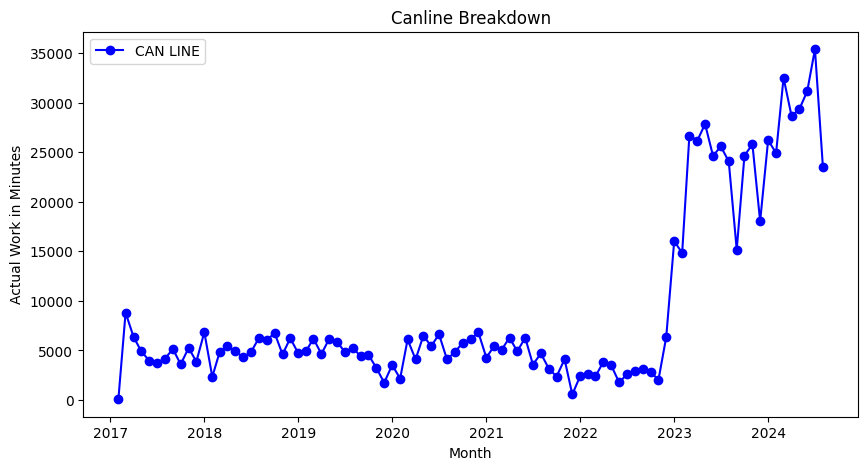

In [20]:
can_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
can_plot_df = can_plot_df.reset_index()
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(can_plot_df['Month'], can_plot_df['ACTUAL_WORK_IN_MINUTES'], label='CAN LINE', marker='o', linestyle='-', color='b')
# Line plot with markers
plt.title('Canline Breakdown')
plt.xlabel('Month')
plt.ylabel('Actual Work in Minutes')
plt.legend()
plt.show()

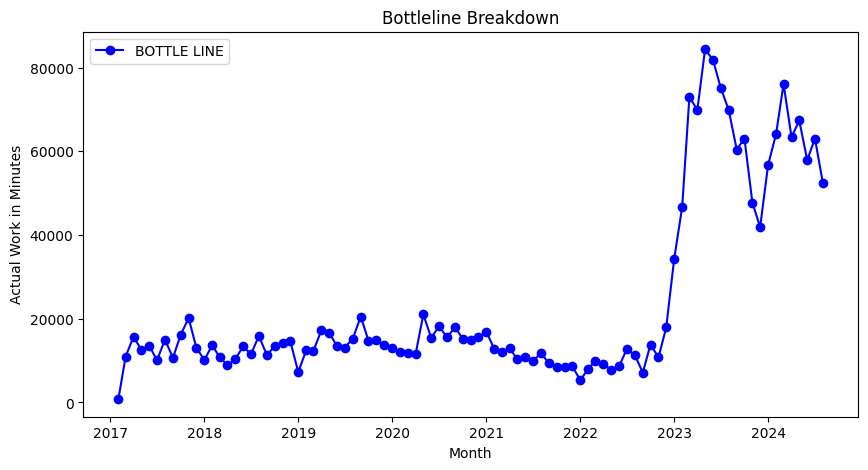

In [21]:
plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'BTL_PET_LINE'].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='BOTTLE LINE', marker='o', linestyle='-', color='b')
# Line plot with markers
plt.title('Bottleline Breakdown')
plt.xlabel('Month')
plt.ylabel('Actual Work in Minutes')
plt.legend()
plt.show()

# ACF Canline

<Figure size 1000x600 with 0 Axes>

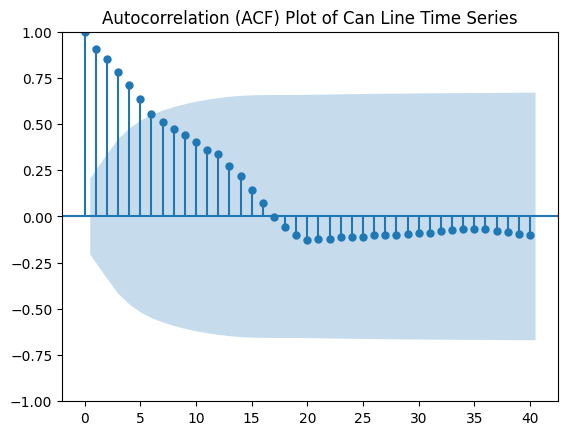

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the 'ORDER_ID' time series data
time_series = can_plot_df['ACTUAL_WORK_IN_MINUTES']

# Create the ACF plot
plt.figure(figsize=(10, 6))
plot_acf(time_series, lags=40)  # You can change lags as needed
plt.title('Autocorrelation (ACF) Plot of Can Line Time Series')
plt.show()

#  ACF Bottle Line

<Figure size 1000x600 with 0 Axes>

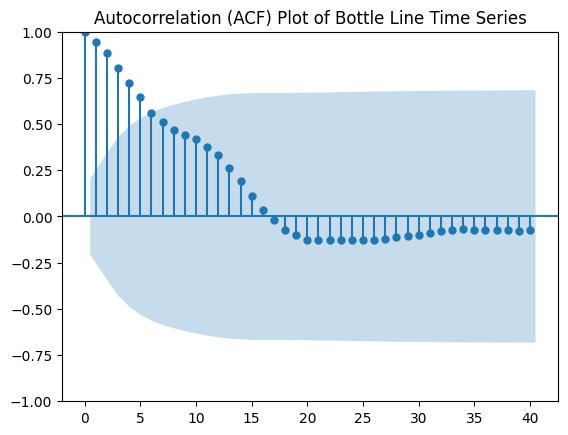

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract the 'ORDER_ID' time series data
time_series = plot_df['ACTUAL_WORK_IN_MINUTES']

# Create the ACF plot
plt.figure(figsize=(10, 6))
plot_acf(time_series, lags=40)  # You can change lags as needed
plt.title('Autocorrelation (ACF) Plot of Bottle Line Time Series')
plt.show()

### Set to Weekly View for Predicted Time in Minutes

In [24]:
# Ensure the date column is in the correct format for weekly aggregation
df['START_YEAR_WEEK'] = df['EXECUTION_START_DATE'].dt.to_period('W').dt.to_timestamp()

# Aggregate the data by week
weekly_data = df.groupby('START_YEAR_WEEK')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Rename columns to match Prophet's requirements
weekly_data.columns = ['ds', 'y']

# Display the first few rows of the prepared data for Prophet
weekly_data.head()

ds        y
0 2017-02-20   2092.0
1 2017-02-27  39945.6
2 2017-03-06  47359.2
3 2017-03-13  44231.0
4 2017-03-20  52335.8

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/teno08z5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/3me0eulo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19109', 'data', 'file=/tmp/tmp8ovekdqu/teno08z5.json', 'init=/tmp/tmp8ovekdqu/3me0eulo.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modeljb9eop7b/prophet_model-20241125233841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 89892655.95399141
R-squared: -0.016611036039742677


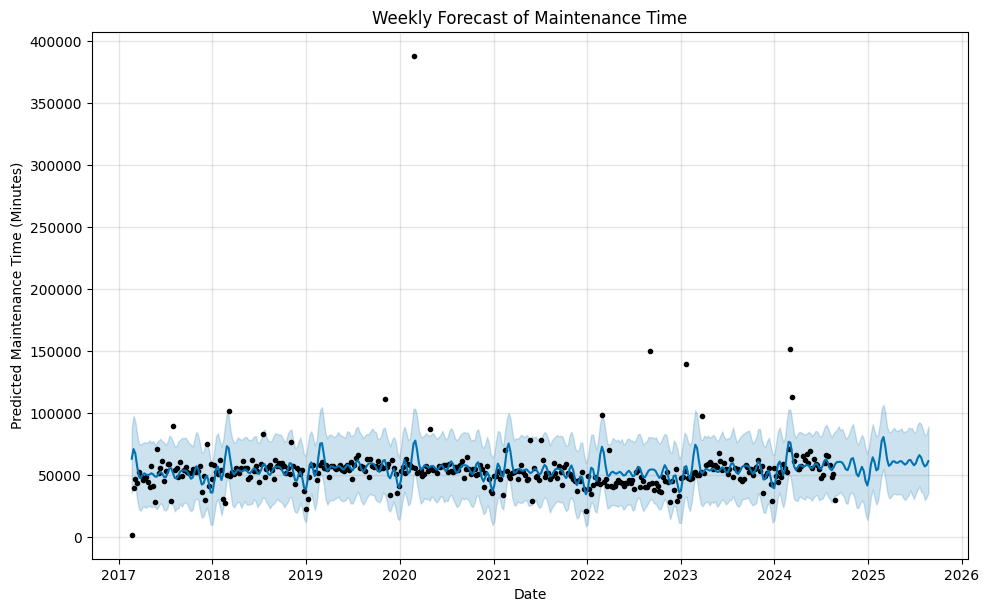

In [25]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Prophet model
model = Prophet()

# Fit the model on the aggregated weekly data
model.fit(weekly_data)

# Define the prediction horizon (next 52 weeks)
future = model.make_future_dataframe(periods=52, freq='W')

# Generate forecast
forecast = model.predict(future)

# Define the validation period (last 12 weeks of actual data)
validation_period = weekly_data['ds'][-12:]
actual_values = weekly_data.set_index('ds').loc[validation_period, 'y']
predicted_values = forecast.set_index('ds').loc[validation_period, 'yhat']

# Calculate performance metrics
mse = mean_squared_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

# Output the performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared:", r2)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Weekly Forecast of Maintenance Time")
plt.xlabel("Date")
plt.ylabel("Predicted Maintenance Time (Minutes)")
plt.show()

In [26]:
grouped_data = df.groupby(['EQUIPMENT_DESC'])['MAINTENANCE_ACTIVITY_TYPE'].count()
# Reset the index to convert the result to a DataFrame
grouped_data = grouped_data.reset_index()

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

df_for_list = grouped_data[grouped_data['Activity_Count']> 500]
equipment_list = df_for_list['EQUIPMENT_DESC'].tolist()

grouped_data = df.groupby('FUNCTIONAL_AREA_NODE_2_MODIFIED')['ACTUAL_WORK_IN_MINUTES'].sum()
grouped_data = grouped_data.reset_index()
grouped_data.sort_values(by='ACTUAL_WORK_IN_MINUTES', ascending=False)

# Rename the count column
grouped_data = grouped_data.rename(columns={'MAINTENANCE_ACTIVITY_TYPE': 'Activity_Count'})

pearson_breakdown_list = grouped_data['FUNCTIONAL_AREA_NODE_2_MODIFIED'].tolist()

In [27]:
def compute_truncated_pearson(list1, list2):
    # Truncate the lists to the same length
    min_len = min(len(list1), len(list2))
    truncated_list1 = list1[:min_len]
    truncated_list2 = list2[:min_len]

    # Compute Pearson correlation
    correlation, p_value = pearsonr(truncated_list1, truncated_list2)
    return correlation, p_value

def iterative_pearson_correlation():
    # Initialize the results list before the loops
    results_list = []

    # Get unique filter values from each dataframe
    filter_values1 = equipment_list  # Assuming this is defined
    filter_values2 = pearson_breakdown_list  # Assuming this is defined

    for filter1 in filter_values1:
        equip_plot_df = df[df['EQUIPMENT_DESC'] == filter1].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
        equip_plot_df = equip_plot_df.reset_index()
        equip_plot_df = equip_plot_df[(equip_plot_df['Month'] >= '2018-01-01') & (equip_plot_df['Month'] <= '2024-06-01')]
        replacement_list = equip_plot_df['ACTUAL_WORK_IN_MINUTES'].tolist()

        for filter2 in filter_values2:
            breakdown_plot_df = df[df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == filter2].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
            breakdown_plot_df = breakdown_plot_df.reset_index()
            breakdown_plot_df = breakdown_plot_df[(breakdown_plot_df['Month'] >= '2018-01-01') & (breakdown_plot_df['Month'] <= '2024-06-01')]
            breakdown_list = breakdown_plot_df['ACTUAL_WORK_IN_MINUTES'].tolist()

            # Check if both lists have at least 2 elements
            if len(replacement_list) >= 2 and len(breakdown_list) >= 2:
                # Compute Pearson correlation
                correlation, p_value = compute_truncated_pearson(replacement_list, breakdown_list)
                # print(f"Correlation between {filter1} and {filter2}: {correlation}, p-value: {p_value}")

                # Append results to the results list
                results_list.append({
                    'Filter1': filter1,
                    'Filter2': filter2,
                    'Correlation': correlation,
                    'P-Value': p_value
                })
            else:
              pass
                # Log the case where the lists are too short
                # print(f"Skipping correlation for {filter1} and {filter2} due to insufficient data.")

    # Convert results list to DataFrame after processing all combinations
    results_df = pd.DataFrame(results_list)
    return results_df

# Call the function
results_df = iterative_pearson_correlation()

In [28]:
results_df[
    (results_df['Correlation'] > 0.6) &
    (results_df['Filter2'] == 'ROTARY_CAN_LINE')
].sort_values(by='Correlation', ascending=False)


Filter1          Filter2  Correlation  \
359  L4 FILLER_ROTARY_CAN_100_VALVE  ROTARY_CAN_LINE     0.965534   
152   L2 FILLER_ROTARY_BTL_45_VALVE  ROTARY_CAN_LINE     0.934217   
267  L3 FILLER_ROTARY_BTL_100_VALVE  ROTARY_CAN_LINE     0.926429   
198        L2 PALLETIZER_LINE 2_PAI  ROTARY_CAN_LINE     0.876522   
83    L1 FILLER_ROTARY_BTL_60_VALVE  ROTARY_CAN_LINE     0.839159   
474           LINE 1 LABELER_ROTARY  ROTARY_CAN_LINE     0.833317   
520             LINE 1 RINSER_IONIC  ROTARY_CAN_LINE     0.822070   
313            L3 PACKER KHS TSP80V  ROTARY_CAN_LINE     0.819323   
405                L4 SEAMER_ROTARY  ROTARY_CAN_LINE     0.739504   
451           LINE 1 DEPAL_ELECPNEU  ROTARY_CAN_LINE     0.733283   
382                  L4 PACKER_CASE  ROTARY_CAN_LINE     0.703703   
244          L3 DEPAL_ELECPNEU_ CAN  ROTARY_CAN_LINE     0.653082   
290               L3 LABELER_ROTARY  ROTARY_CAN_LINE     0.645432   
543         LINE 1 RINSER_LOWERATOR  ROTARY_CAN_LINE     0.630935   
60                   L1 CAPPER_RTRY  ROTARY_CAN_LINE     0.609736   

          P-Value  
359  3.532630e-46  
152  9.213239e-36  
267  5.595681e-34  
198  7.647681e-26  
83   8.562270e-22  
474  2.963521e-21  
520  2.841212e-20  
313  4.817981e-20  
405  1.577547e-14  
451  2.275914e-14  
382  6.695711e-13  
244  1.617349e-10  
290  2.343032e-10  
543  5.950803e-10  
60   3.120994e-09

In [29]:
equipment_ts = results_df[
    (results_df['Correlation'] > 0.6) &
    (results_df['Filter2'] == 'ROTARY_CAN_LINE')
].sort_values(by='Correlation', ascending=False).head(3)

In [30]:
equipment_list = equipment_ts['Filter1'].tolist()

print(equipment_list)

['L4 FILLER_ROTARY_CAN_100_VALVE', 'L2 FILLER_ROTARY_BTL_45_VALVE', 'L3 FILLER_ROTARY_BTL_100_VALVE']


# Correlation Plots

## L4 FILLER_ROTARY_CAN_100_VALVE

In [31]:
plot_df = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['Month'] >= '2022-01-01')  # Filter for dates greater than or equal to 2022-01-01
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()


break_plot_df = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Month']>= '2022-01-01')].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()


## Plot for cans

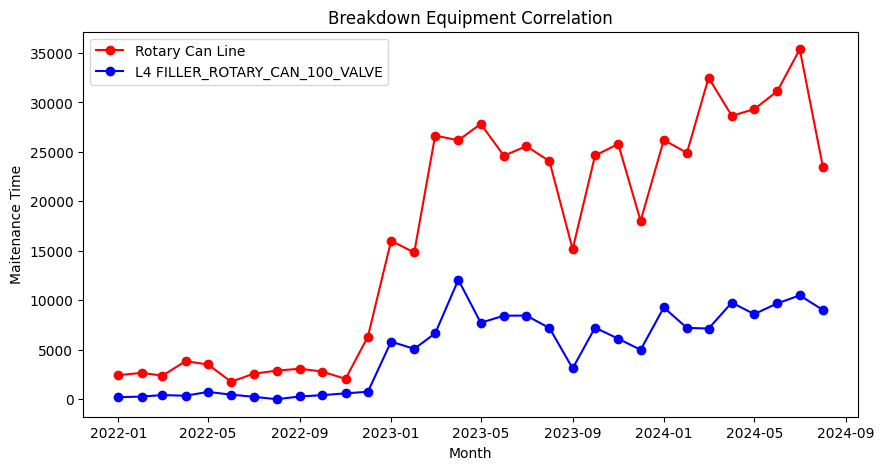

In [32]:
plt.figure(figsize=(10, 5))  # Set the figure size


plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r')
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L4 FILLER_ROTARY_CAN_100_VALVE', marker='o', linestyle='-', color='b')
plt.title('Breakdown Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Maitenance Time')
plt.legend()
plt.show()

In [33]:
plot_df = df[
    (df['EQUIPMENT_DESC'] == 'L2 FILLER_ROTARY_BTL_45_VALVE') &
    (df['Month'] >= '2022-01-01')  # Filter for dates greater than or equal to 2022-01-01
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()


break_plot_df = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Month']>= '2022-01-01')].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()

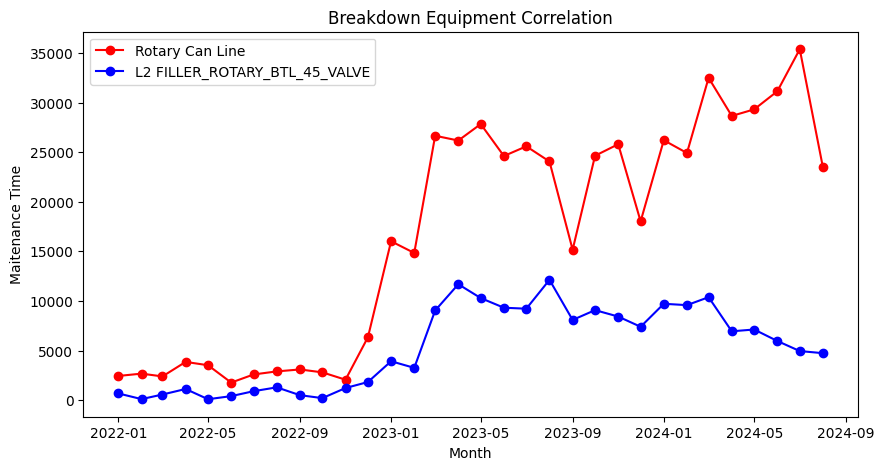

In [34]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r')
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L2 FILLER_ROTARY_BTL_45_VALVE', marker='o', linestyle='-', color='b')
plt.title('Breakdown Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Maitenance Time')
plt.legend()
plt.show()

In [35]:
plot_df = df[
    (df['EQUIPMENT_DESC'] == 'L3 FILLER_ROTARY_BTL_100_VALVE') &
    (df['Month'] >= '2022-01-01')  # Filter for dates greater than or equal to 2022-01-01
].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
plot_df = plot_df.reset_index()

break_plot_df = df[
    (df['FUNCTIONAL_AREA_NODE_2_MODIFIED'] == 'ROTARY_CAN_LINE') &
    (df['Month']>= '2022-01-01')].groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum()
break_plot_df = break_plot_df.reset_index()

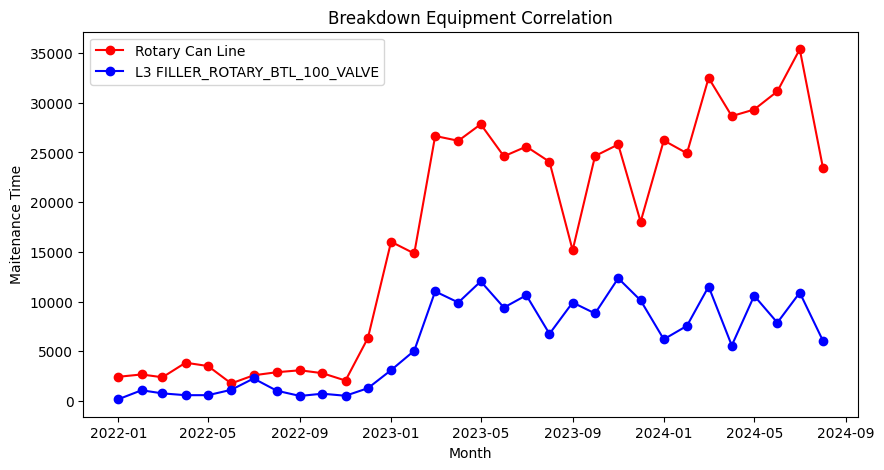

In [36]:
plt.figure(figsize=(10, 5))  # Set the figure size
plt.plot(break_plot_df['Month'], break_plot_df['ACTUAL_WORK_IN_MINUTES'], label='Rotary Can Line', marker='o', linestyle='-', color='r')
plt.plot(plot_df['Month'], plot_df['ACTUAL_WORK_IN_MINUTES'], label='L3 FILLER_ROTARY_BTL_100_VALVE', marker='o', linestyle='-', color='b')
plt.title('Breakdown Equipment Correlation')
plt.xlabel('Month')
plt.ylabel('Maitenance Time')
plt.legend()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/j7mq9uf2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/z5dr9d2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59296', 'data', 'file=/tmp/tmp8ovekdqu/j7mq9uf2.json', 'init=/tmp/tmp8ovekdqu/z5dr9d2o.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelst0w_xtj/prophet_model-20241125233853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


L4 FILLER_ROTARY_CAN_100_VALVE
Mean Squared Error (MSE): 20962.50272089899
R-squared: 0.12870646048793133


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/gfbzuql1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7rd2i3df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87508', 'data', 'file=/tmp/tmp8ovekdqu/gfbzuql1.json', 'init=/tmp/tmp8ovekdqu/7rd2i3df.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model8v04gjwh/prophet_model-20241125233853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


L2 FILLER_ROTARY_BTL_45_VALVE


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7v6ycj6m.json


Mean Squared Error (MSE): 66977.86780803757
R-squared: 0.08556336012356391
L3 FILLER_ROTARY_BTL_100_VALVE


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/upzzoohd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97637', 'data', 'file=/tmp/tmp8ovekdqu/7v6ycj6m.json', 'init=/tmp/tmp8ovekdqu/upzzoohd.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model6o8pyzj0/prophet_model-20241125233854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:38:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 70508.30046425042
R-squared: 0.08200280422570438


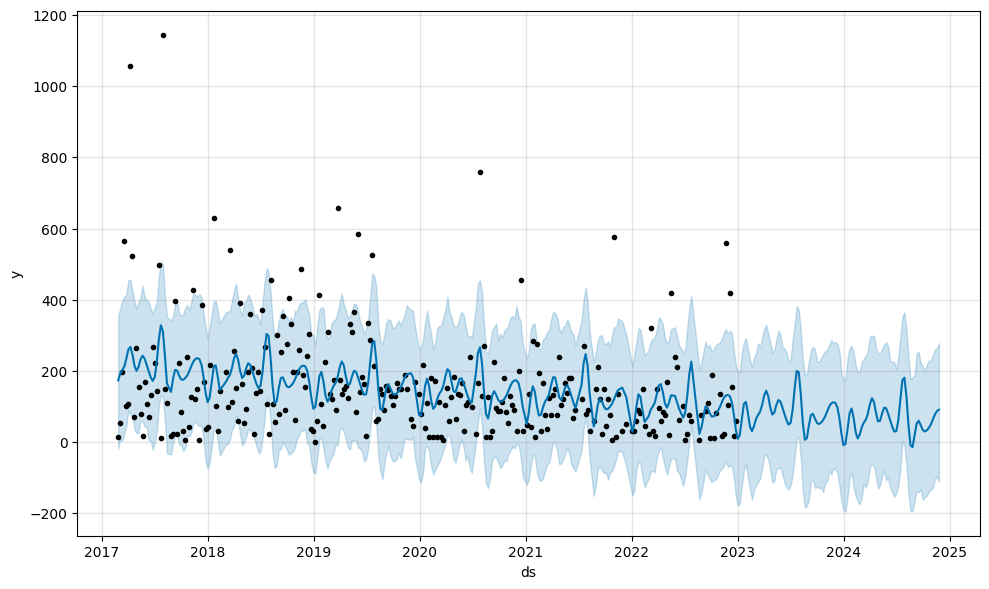

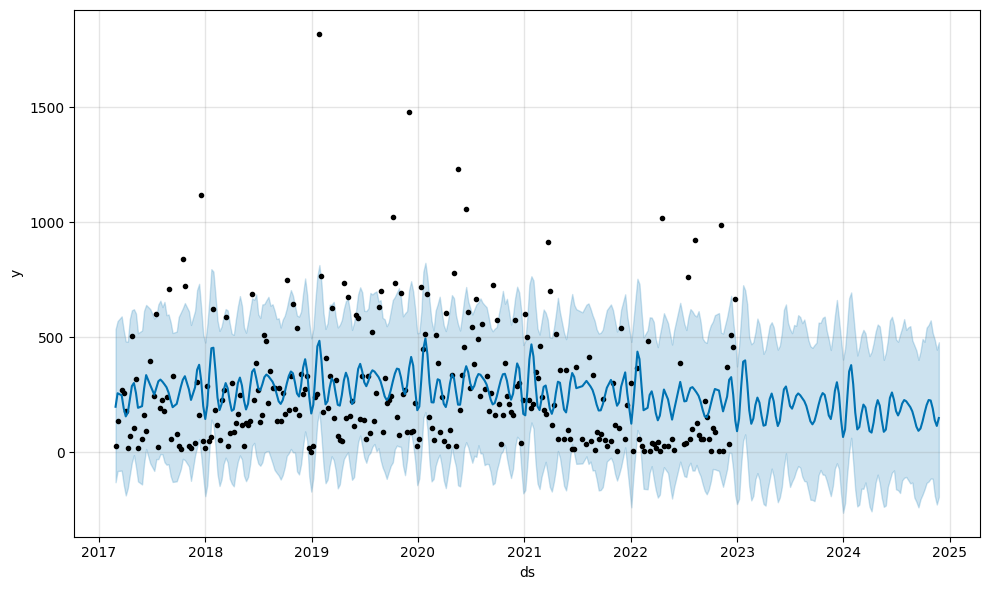

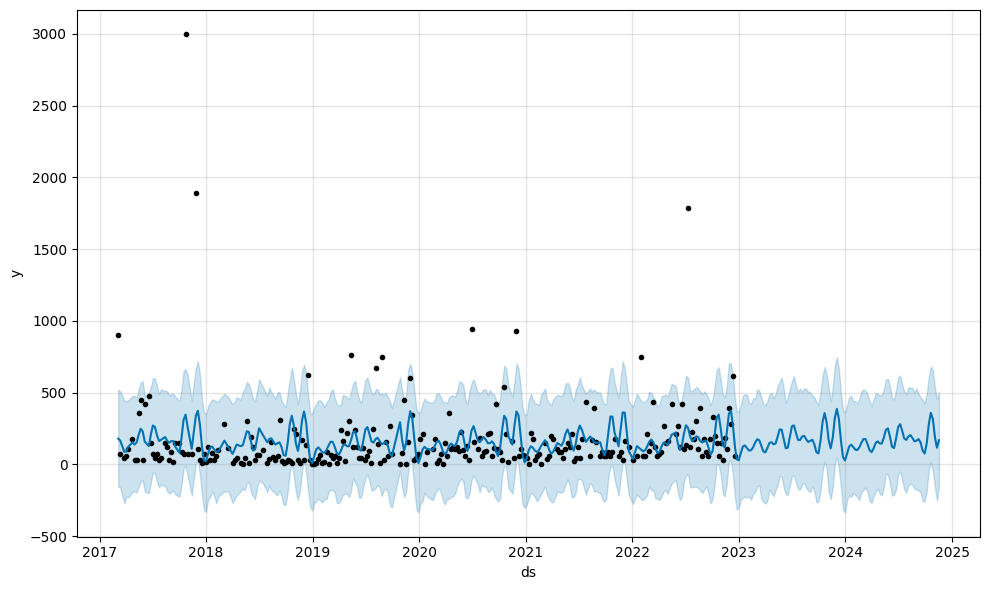

In [37]:
for equipment in equipment_list:
  print(equipment)
  rotary_can_ts = df[
      (df['EQUIPMENT_DESC'] == equipment) &
      (df['Week'] < '2023-01-01')
  ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
  rotary_can_ts = rotary_can_ts.reset_index()

  rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

  # Prepare the data for Prophet
  prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

  # Fit the Prophet model
  model = Prophet()
  model.fit(prophet_data)

  # Make a future DataFrame for predictions (for the next 12 months)
  future = model.make_future_dataframe(periods=100, freq='W')

  # Make predictions
  forecast = model.predict(future)

  # Evaluate the model
  # Align the predictions with actual data
  predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
  actual = rotary_can_ts.set_index('Week')

  # Calculate performance metrics
  mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
  r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

  # Output results
  print("Mean Squared Error (MSE):", mse)
  print("R-squared:", r2)

  # Plot the forecast
  model.plot(forecast)

In [38]:
for equipment in equipment_list:
  print(equipment)
  rotary_can_ts = df[
      (df['EQUIPMENT_DESC'] == equipment) &
      (df['Week'] > '2023-01-01') &
      (df['Week'] < '2024-08-01')
  ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
  rotary_can_ts = rotary_can_ts.reset_index()

  rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

  # Prepare the data for Prophet
  prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

  # Fit the Prophet model
  # model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
  # model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  # model = Prophet()
  model = Prophet()
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(prophet_data)

  # Make a future DataFrame for predictions (for the next 12 months)
  future = model.make_future_dataframe(periods=20, freq='W')

  # Make predictions
  forecast = model.predict(future)

april_2024_forecast = forecast[
    (forecast['ds'] >= '2024-04-01') &
    (forecast['ds'] <= '2024-04-30')]
april_2024_forecast.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/zoxwntmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/vrm9j84x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50255', 'data', 'file=/tmp/tmp8ovekdqu/zoxwntmc.json', 'init=/tmp/tmp8ovekdqu/vrm9j84x.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelnq1z2l38/prophet_model-20241125233855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:55 - cmdstanpy - INFO - Chai

L4 FILLER_ROTARY_CAN_100_VALVE


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/dgdpbkvk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/u4sc3uj0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54818', 'data', 'file=/tmp/tmp8ovekdqu/dgdpbkvk.json', 'init=/tmp/tmp8ovekdqu/u4sc3uj0.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modellvh7tax4/prophet_model-20241125233855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 FILLER_ROTARY_BTL_45_VALVE


23:38:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/30kmeh00.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/gn0e_jsy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67268', 'data', 'file=/tmp/tmp8ovekdqu/30kmeh00.json', 'init=/tmp/tmp8ovekdqu/gn0e_jsy.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model6dbq5zaj/prophet_model-20241125233855.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:55 - cmdstanpy - INFO - Chain 

L3 FILLER_ROTARY_BTL_100_VALVE


23:38:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds        trend   yhat_lower   yhat_upper  trend_lower  \
65 2024-04-01  2174.504608   708.188912  2987.647669  2174.504608   
66 2024-04-08  2178.982984   501.797637  2865.410891  2178.982984   
67 2024-04-15  2183.461359  1013.374970  3362.599403  2183.461359   
68 2024-04-22  2187.939735   545.391127  2944.963229  2187.939735   
69 2024-04-29  2192.418110  1155.794624  3542.841682  2192.418110   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
65  2174.504608     -328.195799           -328.195799           -328.195799   
66  2178.982984     -455.841106           -455.841106           -455.841106   
67  2183.461359      -63.060594            -63.060594            -63.060594   
68  2187.939735     -427.043288           -427.043288           -427.043288   
69  2192.418110      204.253496            204.253496            204.253496   

       monthly  monthly_lower  monthly_upper  multiplicative_terms  \
65 -328.195799    -328.195799    -328.195799                   0.0   
66 -455.841106    -455.841106    -455.841106                   0.0   
67  -63.060594     -63.060594     -63.060594                   0.0   
68 -427.043288    -427.043288    -427.043288                   0.0   
69  204.253496     204.253496     204.253496                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
65                         0.0                         0.0  1846.308809  
66                         0.0                         0.0  1723.141878  
67                         0.0                         0.0  2120.400765  
68                         0.0                         0.0  1760.896447  
69                         0.0                         0.0  2396.671606

  ## Evaluate the model
  ### Align the predictions with actual data


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491



Text(74.59722222222221, 0.5, 'Actual Work in Minutes')

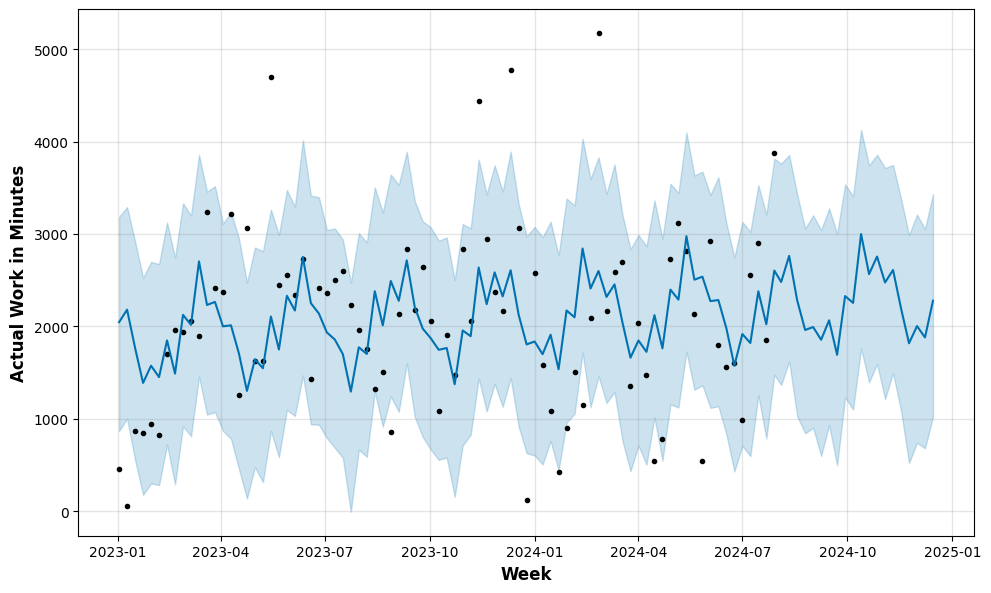

In [39]:
  # Evaluate the model
  # Align the predictions with actual data
  predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
  actual = rotary_can_ts.set_index('Week')


  # Calculate performance metrics
  mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
  r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

  # Output results
  print()
  print("Mean Squared Error (MSE):", mse)
  print("R-squared:", r2)
  print()
  # Plot the forecast
  # model.plot(forecast)


  # Plot the forecast
  fig = model.plot(forecast)

  # Change x-axis and y-axis labels
  ax = fig.gca()  # Get the current axes
  ax.set_xlabel("Week", fontsize=12, fontweight="bold")  # Set x-axis label
  ax.set_ylabel("Actual Work in Minutes", fontsize=12, fontweight="bold")  # Set y-axis label

### Show Actual Maintenance Time for Equipment

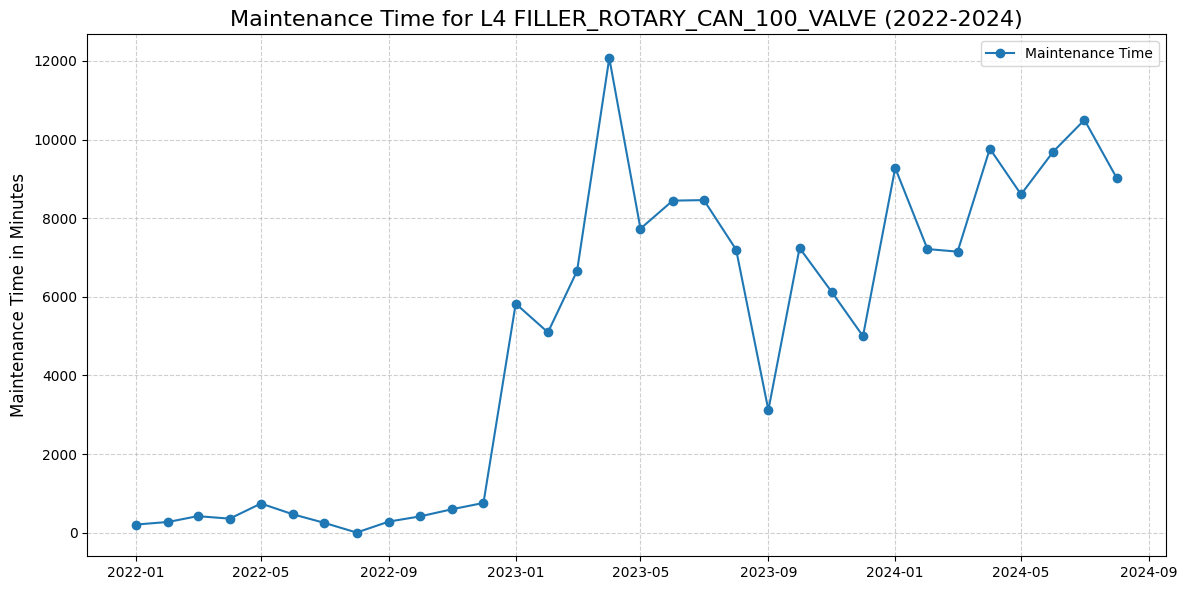

In [40]:
# Filter data for the specified equipment and date range
filtered_data = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['EXECUTION_START_DATE'] >= '2022-01-01') &
    (df['EXECUTION_START_DATE'] <= '2024-12-31')
]

# Group data by month and sum the maintenance time
filtered_data['Month'] = pd.to_datetime(filtered_data['EXECUTION_START_DATE']).dt.to_period('M').dt.to_timestamp()
monthly_maintenance_time = filtered_data.groupby('Month')['ACTUAL_WORK_IN_MINUTES'].sum().reset_index()

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_maintenance_time['Month'], monthly_maintenance_time['ACTUAL_WORK_IN_MINUTES'], marker='o', label='Maintenance Time')
plt.title('Maintenance Time for L4 FILLER_ROTARY_CAN_100_VALVE (2022-2024)', fontsize=16)
# plt.xlabel('Month', fontsize=12)
plt.ylabel('Maintenance Time in Minutes', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

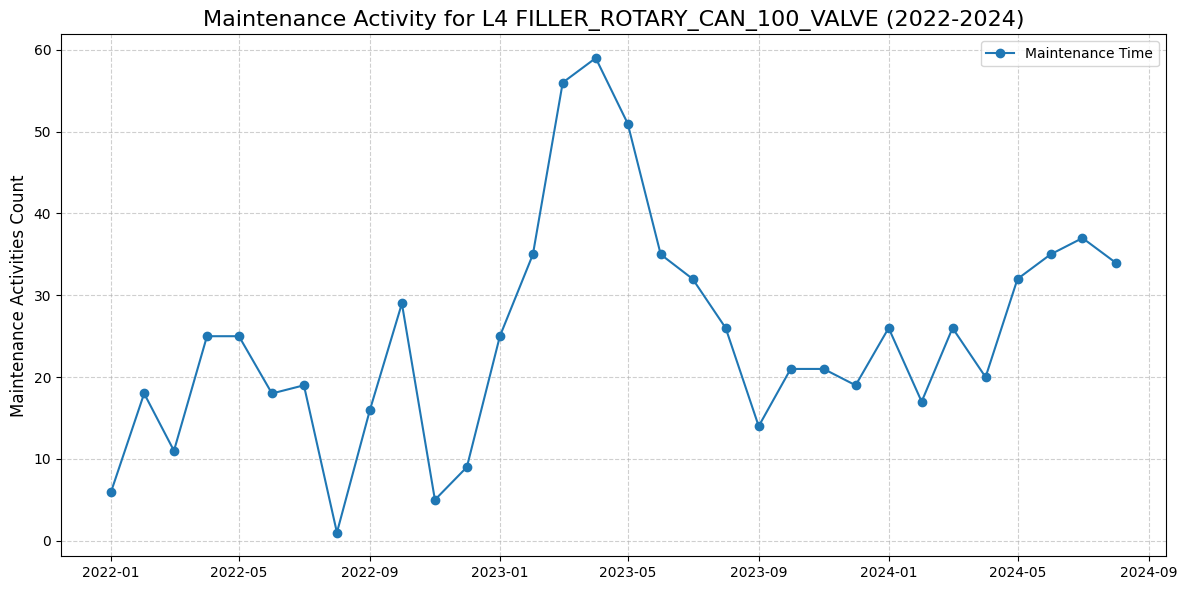

In [41]:
# Filter data for the specified equipment and date range
filtered_data_new = df[
    (df['EQUIPMENT_DESC'] == 'L4 FILLER_ROTARY_CAN_100_VALVE') &
    (df['EXECUTION_START_DATE'] >= '2022-01-01') &
    (df['EXECUTION_START_DATE'] <= '2024-12-31')
]

# Group data by month and sum the maintenance time
filtered_data_new['Month'] = pd.to_datetime(filtered_data['EXECUTION_START_DATE']).dt.to_period('M').dt.to_timestamp()
monthly_maintenance_time = filtered_data_new.groupby('Month')['ACTUAL_WORK_IN_MINUTES'].count().reset_index()

# Plot the graph
plt.figure(figsize=(12, 6))
plt.plot(monthly_maintenance_time['Month'], monthly_maintenance_time['ACTUAL_WORK_IN_MINUTES'], marker='o', label='Maintenance Time')
plt.title('Maintenance Activity for L4 FILLER_ROTARY_CAN_100_VALVE (2022-2024)', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('Maintenance Activities Count', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Aggregations

In [42]:
# Separate DataFrames for planned and unplanned maintenance
planned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned']
unplanned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Group and calculate aggregates for planned maintenance
planned_agg = planned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_planned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_planned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Group and calculate aggregates for unplanned maintenance
unplanned_agg = unplanned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_unplanned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_unplanned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge the two aggregated DataFrames on the common columns
agg_df = pd.merge(planned_agg, unplanned_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Calculate overall average minutes and count from the original DataFrame
overall_agg = df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge with the overall data
agg_df = pd.merge(agg_df, overall_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Filter the final DataFrame based on conditions
agg_df['time_saved'] = (agg_df['average_minutes_unplanned'] - agg_df['average_minutes_planned']).fillna(0)

agg_df['ratio_jobs'] = agg_df['count_planned'] / agg_df['count']

agg_df['ratio_minutes'] = agg_df['average_minutes_planned'] / agg_df['average_minutes_unplanned']

planned_vs_unplanned_key = agg_df

In [43]:
planned_vs_unplanned_key[
    planned_vs_unplanned_key['EQUIPMENT_DESC'].isin(equipment_list)
].sort_values(by='time_saved', ascending=False)

PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  \
292               MONZA                 ROTARY_CAN_LINE   
134               MONZA                    BTL_PET_LINE   
105               MONZA                    BTL_PET_LINE   

                     EQUIPMENT_DESC  average_minutes_planned  count_planned  \
292  L4 FILLER_ROTARY_CAN_100_VALVE                23.188340         2024.0   
134  L3 FILLER_ROTARY_BTL_100_VALVE                52.906592          895.0   
105   L2 FILLER_ROTARY_BTL_45_VALVE                69.941108         1029.0   

     average_minutes_unplanned  count_unplanned  average_minutes  count  \
292                 311.488706            487.0        79.103226   2511   
134                 297.660104            579.0       149.047897   1474   
105                 160.107958           1043.0       115.329151   2072   

     time_saved  ratio_jobs  ratio_minutes  
292  288.300366    0.806053       0.074444  
134  244.753511    0.607191       0.177742  
105   90.166850    0.496622       0.436837

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/kqheq2w6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/fso1x5qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5014', 'data', 'file=/tmp/tmp8ovekdqu/kqheq2w6.json', 'init=/tmp/tmp8ovekdqu/fso1x5qa.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model351vlna_/prophet_model-20241125233858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:38:58 - cmdstanpy - INFO - Chain

L4 FILLER_ROTARY_CAN_100_VALVE
Mean Squared Error (MSE): 587406.7940249428
R-squared: 0.2155564305464549


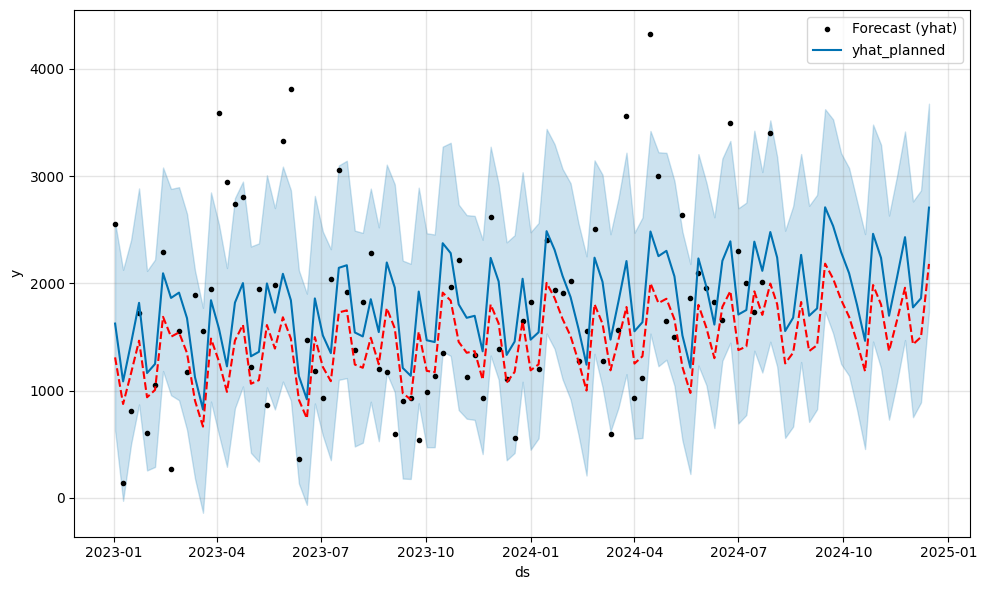

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/2_2qlxst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1jaaosgh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22190', 'data', 'file=/tmp/tmp8ovekdqu/2_2qlxst.json', 'init=/tmp/tmp8ovekdqu/1jaaosgh.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modely32ci1kf/prophet_model-20241125233858.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 FILLER_ROTARY_BTL_45_VALVE


23:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 746924.6208877681
R-squared: 0.053881169655703665


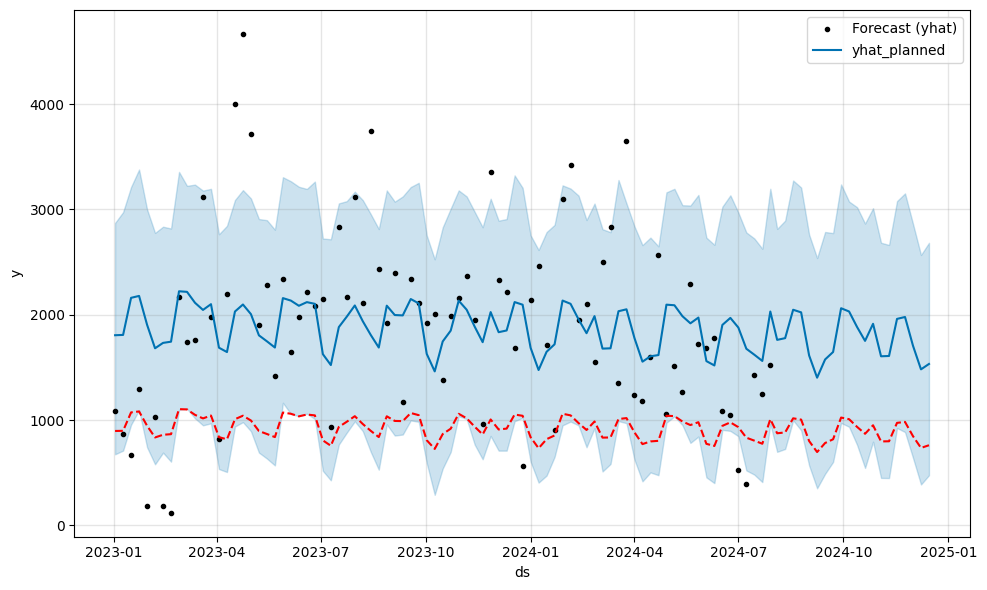

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ufi6z_j7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/7fshdxx9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44312', 'data', 'file=/tmp/tmp8ovekdqu/ufi6z_j7.json', 'init=/tmp/tmp8ovekdqu/7fshdxx9.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model1glf7bi2/prophet_model-20241125233859.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 FILLER_ROTARY_BTL_100_VALVE


23:38:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491


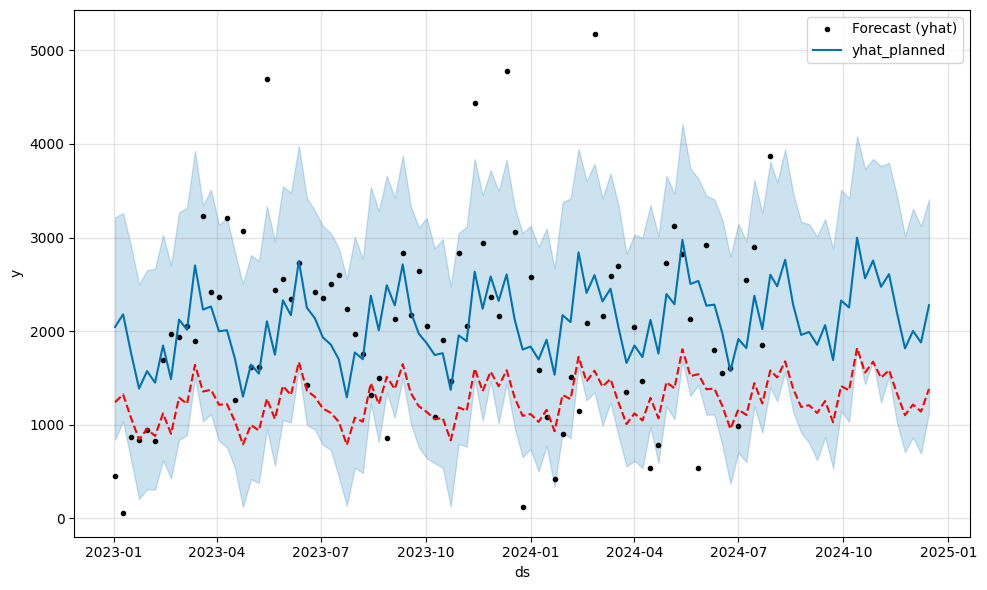

In [44]:
for equipment in equipment_list:
  print(equipment)
  rotary_can_ts = df[
      (df['EQUIPMENT_DESC'] == equipment) &
      (df['Week'] > '2023-01-01') &
      (df['Week'] < '2024-08-01')
  ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
  rotary_can_ts = rotary_can_ts.reset_index()

  rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

  # Prepare the data for Prophet
  prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

  # Fit the Prophet model
  # model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
  # model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  # model = Prophet()
  model = Prophet()
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(prophet_data)

  # Make a future DataFrame for predictions (for the next 12 months)
  future = model.make_future_dataframe(periods=20, freq='W')

  # Make predictions
  forecast = model.predict(future)

  # Evaluate the model
  # Align the predictions with actual data
  predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
  actual = rotary_can_ts.set_index('Week')

  ratio_jobs = planned_vs_unplanned_key.loc[
      planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
  ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

  forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs

  # Calculate performance metrics
  mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
  r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

  # Output results
  print("Mean Squared Error (MSE):", mse)
  print("R-squared:", r2)

  # Plot the forecast
  # Plot the forecast with yhat_planned
  fig = model.plot(forecast)
  ax = fig.gca()  # Get the current axes
  ax.plot(forecast['ds'], forecast['yhat_planned'], label='yhat_planned', color='red', linestyle='--')
  ax.legend(['Forecast (yhat)', 'yhat_planned'])
  plt.show()

In [45]:
# Initialize an empty list to store DataFrames
all_results = []

for equipment in equipment_list:
    print(equipment)
    rotary_can_ts = df[
        (df['EQUIPMENT_DESC'] == equipment) &
        (df['Week'] > '2023-01-01') &
        (df['Week'] < '2024-08-01')
    ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
    rotary_can_ts = rotary_can_ts.reset_index()

    rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

    # Prepare the data for Prophet
    prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_data)

    # Make a future DataFrame for predictions (for the next 12 months)
    future = model.make_future_dataframe(periods=20, freq='W')

    # Make predictions
    forecast = model.predict(future)

    # Align the predictions with actual data
    predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
    actual = rotary_can_ts.set_index('Week')

    ratio_jobs = planned_vs_unplanned_key.loc[
        planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
    ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

    forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs

    # Output results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)

    # Add a description column
    forecast['description'] = equipment
    forecast['original_y'] = pd.merge(forecast, prophet_data, on='ds', how='left')['y']

    # Append the result to the list
    all_results.append(forecast)

# Concatenate all the results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ck39m7nb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/8w6qo1pa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23823', 'data', 'file=/tmp/tmp8ovekdqu/ck39m7nb.json', 'init=/tmp/tmp8ovekdqu/8w6qo1pa.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelksl587k5/prophet_model-20241125233900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chai

L4 FILLER_ROTARY_CAN_100_VALVE


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/hb2kczhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/ie66gnaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86244', 'data', 'file=/tmp/tmp8ovekdqu/hb2kczhn.json', 'init=/tmp/tmp8ovekdqu/ie66gnaa.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelv_1s8wp2/prophet_model-20241125233900.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491
L2 FILLER_ROTARY_BTL_45_VALVE


23:39:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/xe9jzqmz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/rutb2509.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85952', 'data', 'file=/tmp/tmp8ovekdqu/xe9jzqmz.json', 'init=/tmp/tmp8ovekdqu/rutb2509.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modely1oh5tar/prophet_model-20241125233901.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:39:01 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491
L3 FILLER_ROTARY_BTL_100_VALVE


23:39:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491


In [46]:
final_results.head()

ds        trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2023-01-02  1492.193794  717.293544  2656.033502  1492.193794  1492.193794   
1 2023-01-09  1498.578400  100.119186  2027.561597  1498.578400  1498.578400   
2 2023-01-16  1504.963007  507.043327  2427.751423  1504.963007  1504.963007   
3 2023-01-23  1511.347614  823.137600  2861.633473  1511.347614  1511.347614   
4 2023-01-30  1517.732221  183.191393  2119.796324  1517.732221  1517.732221   

   additive_terms  additive_terms_lower  additive_terms_upper     monthly  \
0      133.243434            133.243434            133.243434  133.243434   
1     -412.289298           -412.289298           -412.289298 -412.289298   
2      -61.471928            -61.471928            -61.471928  -61.471928   
3      307.380732            307.380732            307.380732  307.380732   
4     -353.548768           -353.548768           -353.548768 -353.548768   

   monthly_lower  monthly_upper  multiplicative_terms  \
0     133.243434     133.243434                   0.0   
1    -412.289298    -412.289298                   0.0   
2     -61.471928     -61.471928                   0.0   
3     307.380732     307.380732                   0.0   
4    -353.548768    -353.548768                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  \
0                         0.0                         0.0  1625.437227   
1                         0.0                         0.0  1086.289102   
2                         0.0                         0.0  1443.491079   
3                         0.0                         0.0  1818.728347   
4                         0.0                         0.0  1164.183453   

   yhat_planned                     description  original_y  
0   1310.189147  L4 FILLER_ROTARY_CAN_100_VALVE      2550.0  
1    875.606987  L4 FILLER_ROTARY_CAN_100_VALVE       141.0  
2   1163.530842  L4 FILLER_ROTARY_CAN_100_VALVE       810.0  
3   1465.992104  L4 FILLER_ROTARY_CAN_100_VALVE      1725.0  
4    938.393990  L4 FILLER_ROTARY_CAN_100_VALVE       606.0

# High Maintenance Weeks

### Critical Jobs Highlighted and Marked with True Definition Based on Tolerances

In [47]:
critical_plot = final_results.copy()

In [48]:
workload_threshold = final_results['yhat'].quantile(0.8)

# Flag high workload
final_results['higher_workload'] = final_results['yhat'] > workload_threshold

# Maintenance is needed if:
# The item has high workload OR The planned value is significantly lower than actual value
maintenance_threshold = 0.8  # 80% threshold
final_results['maintenance_needed'] = (
    final_results['higher_workload'] |  # If high workload, maintenance is needed
    ((final_results['yhat_planned'] / final_results['yhat']) < maintenance_threshold)  # OR if planned is much lower than actual
)

final_results['critical_job'] = final_results['higher_workload'] & final_results['maintenance_needed']
final_results = final_results.sort_values(by=['ds', 'critical_job'], ascending=[False, False])
final_results['planned_vs_actual_ratio'] = (final_results['yhat_planned'] / final_results['yhat'] * 100).round(2)


columns = [
    'ds', 'description',
    'yhat', 'yhat_planned', 'planned_vs_actual_ratio',
    'higher_workload', 'maintenance_needed', 'critical_job'
]


print("Counts for maintenance_needed:")
print(final_results['maintenance_needed'].value_counts())
print("Counts for critical_job:")
print(final_results['critical_job'].value_counts())


final_results.head(15)

Counts for maintenance_needed:
maintenance_needed
True     228
False     81
Name: count, dtype: int64
Counts for critical_job:
critical_job
False    247
True      62
Name: count, dtype: int64


ds        trend   yhat_lower   yhat_upper  trend_lower  \
102 2024-12-15  2142.530778  1711.660513  3620.265462  2142.530000   
308 2024-12-15  2339.564735  1107.932456  3464.905863  2339.564702   
205 2024-12-15  1765.261430   431.760162  2652.405970  1765.236958   
101 2024-12-08  2136.145761   918.031457  2788.693995  2136.145055   
204 2024-12-08  1767.351297   416.656936  2684.057231  1767.328849   
307 2024-12-08  2335.086359   594.067128  3013.355122  2335.086329   
100 2024-12-01  2129.760745   823.160232  2703.220553  2129.760097   
203 2024-12-01  1769.441164   610.751714  2889.668572  1769.420443   
306 2024-12-01  2330.607984   871.721891  3207.787001  2330.607957   
99  2024-11-24  2123.375728  1429.392556  3396.478024  2123.375141   
202 2024-11-24  1771.531032   926.535414  2997.426022  1771.512509   
305 2024-11-24  2326.129608   535.103153  3033.810587  2326.129584   
98  2024-11-17  2116.990712  1054.294786  3052.624900  2116.990174   
201 2024-11-17  1773.620899   861.289688  3025.579584  1773.604147   
304 2024-11-17  2321.651233   944.696661  3465.142652  2321.651210   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
102  2142.531572      563.797567            563.797567            563.797567   
308  2339.564766      -63.060594            -63.060594            -63.060594   
205  1765.283696     -232.695296           -232.695296           -232.695296   
101  2136.146501     -275.034206           -275.034206           -275.034206   
204  1767.371869     -285.983897           -285.983897           -285.983897   
307  2335.086388     -455.841106           -455.841106           -455.841106   
100  2129.761433     -353.548768           -353.548768           -353.548768   
203  1769.459963      -64.285940            -64.285940            -64.285940   
306  2330.608010     -328.195799           -328.195799           -328.195799   
99   2123.376359      307.380732            307.380732            307.380732   
202  1771.548100      206.911951            206.911951            206.911951   
305  2326.129631     -509.970263           -509.970263           -509.970263   
98   2116.991289      -61.471928            -61.471928            -61.471928   
201  1773.636618      186.640672            186.640672            186.640672   
304  2321.651254     -126.791816           -126.791816           -126.791816   

        monthly  ...  multiplicative_terms_lower  multiplicative_terms_upper  \
102  563.797567  ...                         0.0                         0.0   
308  -63.060594  ...                         0.0                         0.0   
205 -232.695296  ...                         0.0                         0.0   
101 -275.034206  ...                         0.0                         0.0   
204 -285.983897  ...                         0.0                         0.0   
307 -455.841106  ...                         0.0                         0.0   
100 -353.548768  ...                         0.0                         0.0   
203  -64.285940  ...                         0.0                         0.0   
306 -328.195799  ...                         0.0                         0.0   
99   307.380732  ...                         0.0                         0.0   
202  206.911951  ...                         0.0                         0.0   
305 -509.970263  ...                         0.0                         0.0   
98   -61.471928  ...                         0.0                         0.0   
201  186.640672  ...                         0.0                         0.0   
304 -126.791816  ...                         0.0                         0.0   

            yhat  yhat_planned                     description  original_y  \
102  2706.328344   2181.445069  L4 FILLER_ROTARY_CAN_100_VALVE         NaN   
308  2276.504141   1382.273545  L3 FILLER_ROTARY_BTL_100_VALVE         NaN   
205  1532.566133    761.105478   L2 FILLER_ROTARY_BTL_45_VALVE         NaN   
101  1861.111555 

In [49]:
workload_threshold = final_results['yhat'].quantile(0.8)  # Top 20% jobs
final_results['higher_workload'] = final_results['yhat'] > workload_threshold

final_results['maintenance_needed'] = final_results['yhat_planned'] < final_results['yhat'] * 0.8

final_results['critical_job'] = final_results['higher_workload'] & final_results['maintenance_needed']

final_results = final_results[['ds', 'trend', 'yhat', 'yhat_planned', 'description', 'original_y',
                               'higher_workload', 'maintenance_needed', 'critical_job']]
final_results = final_results[['ds','trend','yhat','yhat_planned','description','original_y','higher_workload','critical_job','maintenance_needed']]

# final_results = final_results.sort_values(by=['critical_job', 'yhat'], ascending=[False, False])
final_results = final_results.sort_values(by=['ds'], ascending=False)
print("Counts for maintenance_needed:")
print(final_results['maintenance_needed'].value_counts())
print("Counts for critical_job:")
print(final_results['critical_job'].value_counts())

final_results.head(15)


Counts for maintenance_needed:
maintenance_needed
True     206
False    103
Name: count, dtype: int64
Counts for critical_job:
critical_job
False    269
True      40
Name: count, dtype: int64


ds        trend         yhat  yhat_planned  \
102 2024-12-15  2142.530778  2706.328344   2181.445069   
205 2024-12-15  1765.261430  1532.566133    761.105478   
308 2024-12-15  2339.564735  2276.504141   1382.273545   
101 2024-12-08  2136.145761  1861.111555   1500.155232   
307 2024-12-08  2335.086359  1879.245253   1141.061399   
204 2024-12-08  1767.351297  1481.367400    735.679080   
100 2024-12-01  2129.760745  1776.211976   1431.721641   
306 2024-12-01  2330.607984  2002.412185   1215.847290   
203 2024-12-01  1769.441164  1705.155224    846.816953   
99  2024-11-24  2123.375728  2430.756460   1959.319425   
202 2024-11-24  1771.531032  1978.442983    982.537563   
305 2024-11-24  2326.129608  1816.159345   1102.756183   
98  2024-11-17  2116.990712  2055.518783   1656.857833   
201 2024-11-17  1773.620899  1960.261571    973.508280   
304 2024-11-17  2321.651233  2194.859416   1332.699578   

                        description  original_y  higher_workload  \
102  L4 FILLER_ROTARY_CAN_100_VALVE         NaN             True   
205   L2 FILLER_ROTARY_BTL_45_VALVE         NaN            False   
308  L3 FILLER_ROTARY_BTL_100_VALVE         NaN             True   
101  L4 FILLER_ROTARY_CAN_100_VALVE         NaN            False   
307  L3 FILLER_ROTARY_BTL_100_VALVE         NaN            False   
204   L2 FILLER_ROTARY_BTL_45_VALVE         NaN            False   
100  L4 FILLER_ROTARY_CAN_100_VALVE         NaN            False   
306  L3 FILLER_ROTARY_BTL_100_VALVE         NaN            False   
203   L2 FILLER_ROTARY_BTL_45_VALVE         NaN            False   
99   L4 FILLER_ROTARY_CAN_100_VALVE         NaN             True   
202   L2 FILLER_ROTARY_BTL_45_VALVE         NaN            False   
305  L3 FILLER_ROTARY_BTL_100_VALVE         NaN            False   
98   L4 FILLER_ROTARY_CAN_100_VALVE         NaN            False   
201   L2 FILLER_ROTARY_BTL_45_VALVE         NaN            False   
304  L3 FILLER_ROTARY_BTL_100_VALVE         NaN            False   

     critical_job  maintenance_needed  
102         False               False  
205         False                True  
308          True                True  
101         False               False  
307         False                True  
204         False                True  
100         False               False  
306         False                True  
203         False                True  
99          False               False  
202         False                True  
305         False                True  
98          False               False  
201         False                True  
304         False                True

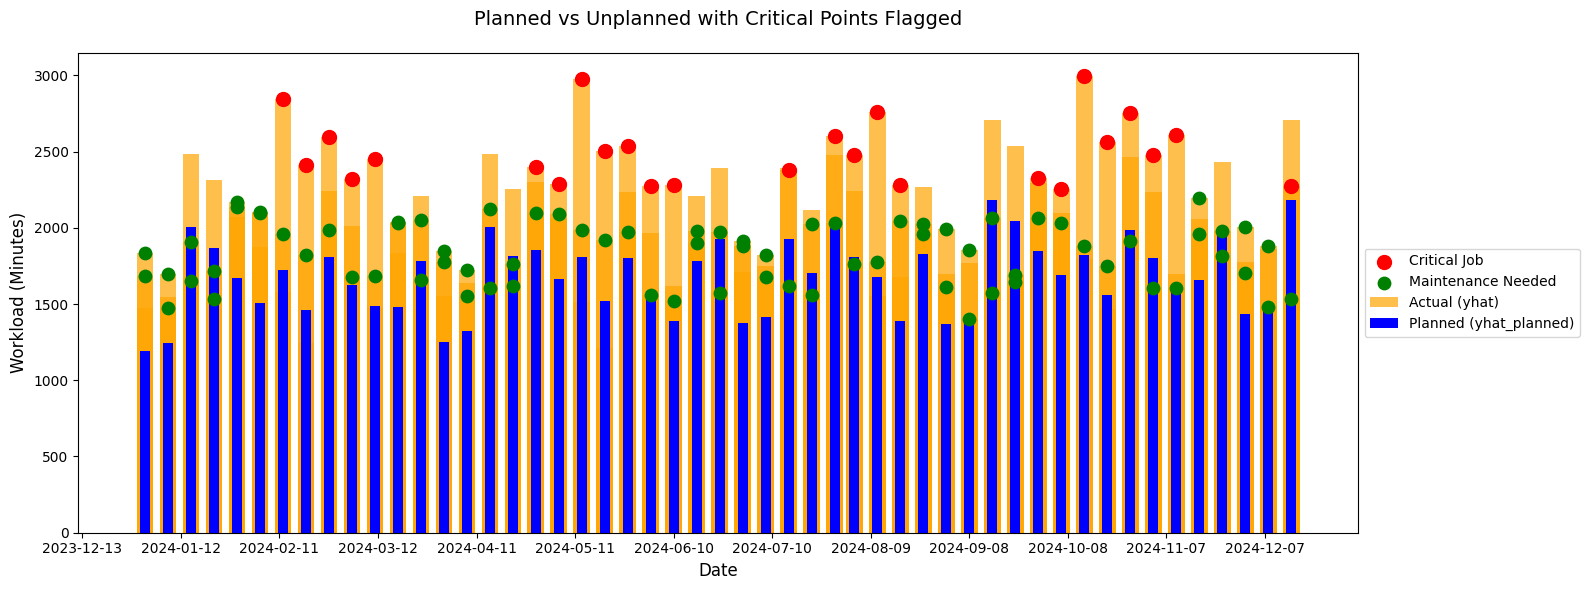

In [50]:
import matplotlib.dates as mdates


# Filter for year >= 2024
final_results = final_results[final_results['ds'] >= '2024-01-01']
plt.figure(figsize=(16, 6))


bar_width = 5
plt.bar(final_results['ds'], final_results['yhat'], color='orange', width=bar_width, label='Actual (yhat)', alpha=0.7)
plt.bar(final_results['ds'], final_results['yhat_planned'], color='blue', width=bar_width * 0.6, label='Planned (yhat_planned)')

# Highlight critical jobs and maintenance-needed jobs
critical_mask = final_results['critical_job']
maintenance_mask = final_results['maintenance_needed']

plt.scatter(final_results[critical_mask]['ds'], final_results[critical_mask]['yhat'],
            color='red', s=100, label='Critical Job', zorder=5)
plt.scatter(final_results[maintenance_mask]['ds'], final_results[maintenance_mask]['yhat'],
            color='green', s=80, label='Maintenance Needed', zorder=4)


plt.title('Planned vs Unplanned with Critical Points Flagged', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Workload (Minutes)', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


# Visualize Batching

In [51]:
# batch_plot = final_results[final_results['batch_group'] <= 79].groupby('batch_group').agg({ # It got ugly after 79. Going to remove for now.
#     'yhat': 'sum',
#     'yhat_planned': 'sum',
#     'original_y': 'sum'
# }).reset_index()

# plt.figure(figsize=(10, 6))
# plt.plot(batch_plot['batch_group'], batch_plot['yhat'], label='Forecasted Workload (yhat)', marker='o')
# plt.plot(batch_plot['batch_group'], batch_plot['yhat_planned'], label='Planned Maintenance (yhat_planned)', marker='o')
# plt.bar(batch_plot['batch_group'], batch_plot['original_y'], alpha=0.6, label='Original Workload')

# plt.title('Batch Maintenance Optimization', fontsize=14)
# plt.xlabel('Batch Group ID', fontsize=12)
# plt.ylabel('Workload (Minutes)', fontsize=12)
# plt.legend(fontsize=10)
# plt.grid(True)
# plt.tight_layout()
# plt.show()



## Aggregations

In [53]:
# Separate DataFrames for planned and unplanned maintenance
planned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Planned']
unplanned_df = df[df['MAINTENANCE_ACTIVITY_TYPE'] == 'Unplanned']

# Group and calculate aggregates for planned maintenance
planned_agg = planned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_planned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_planned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Group and calculate aggregates for unplanned maintenance
unplanned_agg = unplanned_df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes_unplanned=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count_unplanned=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge the two aggregated DataFrames on the common columns
agg_df = pd.merge(planned_agg, unplanned_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Calculate overall average minutes and count from the original DataFrame
overall_agg = df.groupby(['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC']).agg(
    average_minutes=('ACTUAL_WORK_IN_MINUTES', 'mean'),
    count=('ACTUAL_WORK_IN_MINUTES', 'count')
).reset_index()

# Merge with the overall data
agg_df = pd.merge(agg_df, overall_agg, on=['PRODUCTION_LOCATION', 'FUNCTIONAL_AREA_NODE_2_MODIFIED', 'EQUIPMENT_DESC'], how='outer')

# Filter the final DataFrame based on conditions
agg_df['time_saved'] = (agg_df['average_minutes_unplanned'] - agg_df['average_minutes_planned']).fillna(0)

agg_df['ratio_jobs'] = agg_df['count_planned'] / agg_df['count']

agg_df['ratio_minutes'] = agg_df['average_minutes_planned'] / agg_df['average_minutes_unplanned']

planned_vs_unplanned_key = agg_df

In [54]:
planned_vs_unplanned_key[
    planned_vs_unplanned_key['EQUIPMENT_DESC'].isin(equipment_list)
].sort_values(by='time_saved', ascending=False)

PRODUCTION_LOCATION FUNCTIONAL_AREA_NODE_2_MODIFIED  \
292               MONZA                 ROTARY_CAN_LINE   
134               MONZA                    BTL_PET_LINE   
105               MONZA                    BTL_PET_LINE   

                     EQUIPMENT_DESC  average_minutes_planned  count_planned  \
292  L4 FILLER_ROTARY_CAN_100_VALVE                23.188340         2024.0   
134  L3 FILLER_ROTARY_BTL_100_VALVE                52.906592          895.0   
105   L2 FILLER_ROTARY_BTL_45_VALVE                69.941108         1029.0   

     average_minutes_unplanned  count_unplanned  average_minutes  count  \
292                 311.488706            487.0        79.103226   2511   
134                 297.660104            579.0       149.047897   1474   
105                 160.107958           1043.0       115.329151   2072   

     time_saved  ratio_jobs  ratio_minutes  
292  288.300366    0.806053       0.074444  
134  244.753511    0.607191       0.177742  
105   90.166850    0.496622       0.436837

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/nob17yre.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/rhjpvl_k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87523', 'data', 'file=/tmp/tmp8ovekdqu/nob17yre.json', 'init=/tmp/tmp8ovekdqu/rhjpvl_k.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelw9_3r706/prophet_model-20241125234022.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 FILLER_ROTARY_CAN_100_VALVE


23:40:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 587406.7940249428
R-squared: 0.2155564305464549


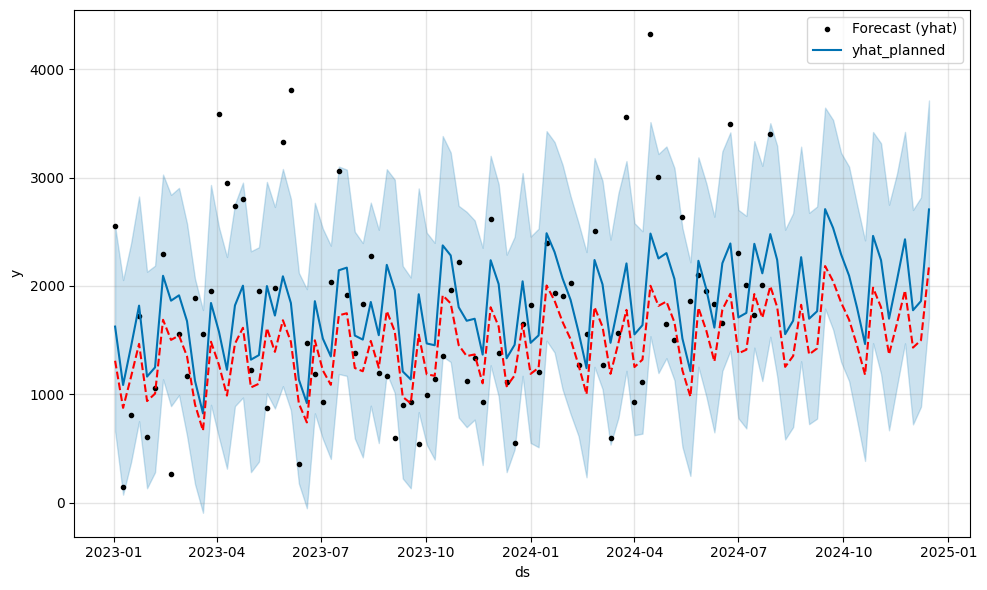

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/1mi60z2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/rehfx1n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29712', 'data', 'file=/tmp/tmp8ovekdqu/1mi60z2a.json', 'init=/tmp/tmp8ovekdqu/rehfx1n7.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelywnkwgrm/prophet_model-20241125234024.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L2 FILLER_ROTARY_BTL_45_VALVE


23:40:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 746924.6208877681
R-squared: 0.053881169655703665


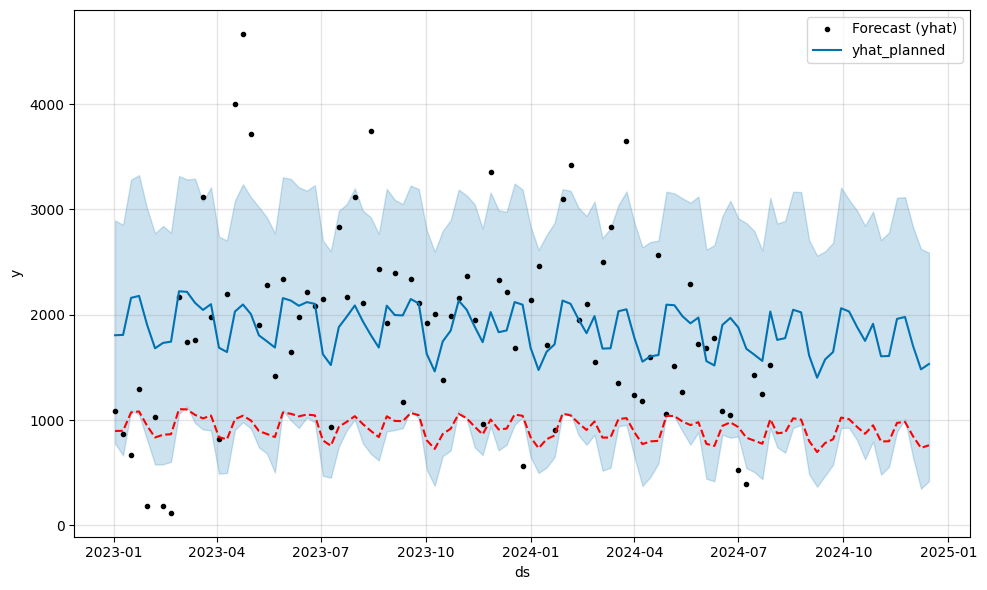

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/8shr7izv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/b9roihe1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26660', 'data', 'file=/tmp/tmp8ovekdqu/8shr7izv.json', 'init=/tmp/tmp8ovekdqu/b9roihe1.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelbfk38inp/prophet_model-20241125234024.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L3 FILLER_ROTARY_BTL_100_VALVE


23:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491


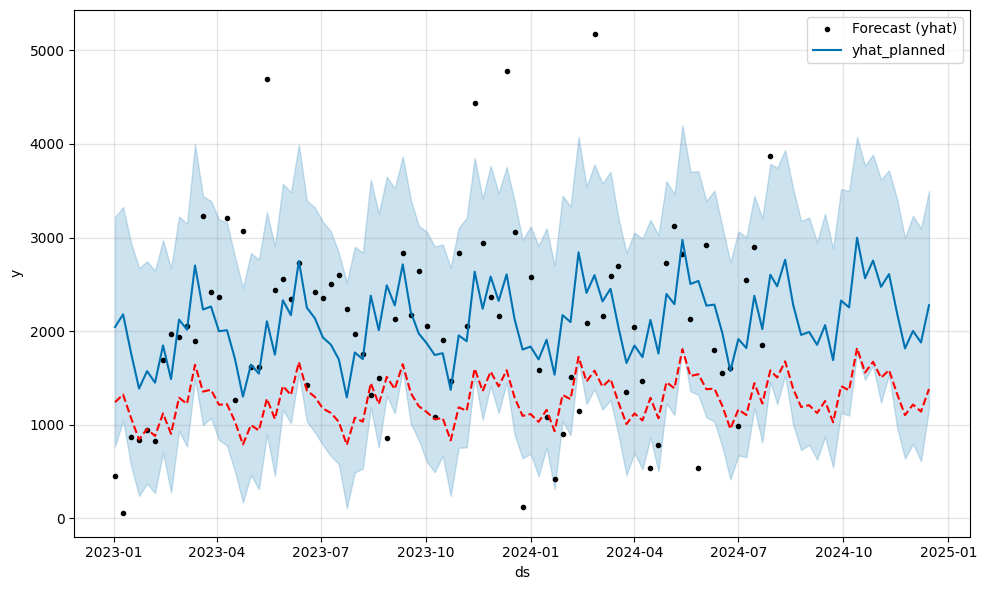

In [55]:
for equipment in equipment_list:
  print(equipment)
  rotary_can_ts = df[
      (df['EQUIPMENT_DESC'] == equipment) &
      (df['Week'] > '2023-01-01') &
      (df['Week'] < '2024-08-01')
  ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
  rotary_can_ts = rotary_can_ts.reset_index()

  rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

  # Prepare the data for Prophet
  prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

  # Fit the Prophet model
  # model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
  # model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  # model = Prophet()
  model = Prophet()
  model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  model.fit(prophet_data)

  # Make a future DataFrame for predictions (for the next 12 months)
  future = model.make_future_dataframe(periods=20, freq='W')

  # Make predictions
  forecast = model.predict(future)

  # Evaluate the model
  # Align the predictions with actual data
  predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
  actual = rotary_can_ts.set_index('Week')

  ratio_jobs = planned_vs_unplanned_key.loc[
      planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
  ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

  forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs


  # Calculate performance metrics
  mse = mean_squared_error(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])
  r2 = r2_score(actual['ACTUAL_WORK_IN_MINUTES'], predicted['yhat'])

  # Output results
  print("Mean Squared Error (MSE):", mse)
  print("R-squared:", r2)

  # Plot the forecast
  # Plot the forecast with yhat_planned
  fig = model.plot(forecast)
  ax = fig.gca()  # Get the current axes
  ax.plot(forecast['ds'], forecast['yhat_planned'], label='yhat_planned', color='red', linestyle='--')
  ax.legend(['Forecast (yhat)', 'yhat_planned'])
  plt.show()

In [56]:
# Initialize an empty list to store DataFrames
all_results = []

for equipment in equipment_list:
    print(equipment)
    rotary_can_ts = df[
        (df['EQUIPMENT_DESC'] == equipment) &
        (df['Week'] > '2023-01-01') &
        (df['Week'] < '2024-08-01')
    ].groupby('Week')['ACTUAL_WORK_IN_MINUTES'].sum()
    rotary_can_ts = rotary_can_ts.reset_index()

    rotary_can_ts['Week'] = pd.to_datetime(rotary_can_ts['Week'])

    # Prepare the data for Prophet
    prophet_data = rotary_can_ts.rename(columns={'Week': 'ds', 'ACTUAL_WORK_IN_MINUTES': 'y'})

    # Fit the Prophet model
    model = Prophet()
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    model.fit(prophet_data)

    # Make a future DataFrame for predictions (for the next 12 months)
    future = model.make_future_dataframe(periods=20, freq='W')

    # Make predictions
    forecast = model.predict(future)

    # Align the predictions with actual data
    predicted = forecast[['ds', 'yhat']].set_index('ds').loc[rotary_can_ts['Week']]
    actual = rotary_can_ts.set_index('Week')

    ratio_jobs = planned_vs_unplanned_key.loc[
        planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'ratio_jobs'
    ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

    forecast['yhat_planned'] = forecast['yhat'] * ratio_jobs

    average_time = planned_vs_unplanned_key.loc[
      planned_vs_unplanned_key['EQUIPMENT_DESC'] == equipment, 'average_minutes'
    ].values[0]  # Ensure you get the correct ratio_jobs for the equipment

    # Output results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared:", r2)

    # Add a description column
    forecast['description'] = equipment
    forecast['original_y'] = pd.merge(forecast, prophet_data, on='ds', how='left')['y']
    forecast['average_jobs'] = round(forecast['yhat'] / average_time)

    # Append the result to the list
    all_results.append(forecast)

# Concatenate all the results into a single DataFrame
final_results = pd.concat(all_results, ignore_index=True)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/nga10ybt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/xar0jp73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91206', 'data', 'file=/tmp/tmp8ovekdqu/nga10ybt.json', 'init=/tmp/tmp8ovekdqu/xar0jp73.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_model7cnpj_mr/prophet_model-20241125234025.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


L4 FILLER_ROTARY_CAN_100_VALVE


23:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/uwpnvjlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/9lnco_72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64970', 'data', 'file=/tmp/tmp8ovekdqu/uwpnvjlr.json', 'init=/tmp/tmp8ovekdqu/9lnco_72.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelod8r0v4u/prophet_model-20241125234026.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:26 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491
L2 FILLER_ROTARY_BTL_45_VALVE


23:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/fvcay6nl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8ovekdqu/qucfxvii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67964', 'data', 'file=/tmp/tmp8ovekdqu/fvcay6nl.json', 'init=/tmp/tmp8ovekdqu/qucfxvii.json', 'output', 'file=/tmp/tmp8ovekdqu/prophet_modelgi1_12zy/prophet_model-20241125234026.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:40:26 - cmdstanpy - INFO - Chain 

Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491
L3 FILLER_ROTARY_BTL_100_VALVE


23:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error (MSE): 862178.3494167012
R-squared: 0.142118336655491


In [57]:
final_results.head()

ds        trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2023-01-02  1492.193794  666.889504  2548.952852  1492.193794  1492.193794   
1 2023-01-09  1498.578400  116.836645  2081.314094  1498.578400  1498.578400   
2 2023-01-16  1504.963007  458.058734  2379.407088  1504.963007  1504.963007   
3 2023-01-23  1511.347614  796.233251  2761.024625  1511.347614  1511.347614   
4 2023-01-30  1517.732221  298.257042  2161.510617  1517.732221  1517.732221   

   additive_terms  additive_terms_lower  additive_terms_upper     monthly  \
0      133.243434            133.243434            133.243434  133.243434   
1     -412.289298           -412.289298           -412.289298 -412.289298   
2      -61.471928            -61.471928            -61.471928  -61.471928   
3      307.380732            307.380732            307.380732  307.380732   
4     -353.548768           -353.548768           -353.548768 -353.548768   

   monthly_lower  monthly_upper  multiplicative_terms  \
0     133.243434     133.243434                   0.0   
1    -412.289298    -412.289298                   0.0   
2     -61.471928     -61.471928                   0.0   
3     307.380732     307.380732                   0.0   
4    -353.548768    -353.548768                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  \
0                         0.0                         0.0  1625.437227   
1                         0.0                         0.0  1086.289102   
2                         0.0                         0.0  1443.491079   
3                         0.0                         0.0  1818.728347   
4                         0.0                         0.0  1164.183453   

   yhat_planned                     description  original_y  average_jobs  
0   1310.189147  L4 FILLER_ROTARY_CAN_100_VALVE      2550.0          21.0  
1    875.606987  L4 FILLER_ROTARY_CAN_100_VALVE       141.0          14.0  
2   1163.530842  L4 FILLER_ROTARY_CAN_100_VALVE       810.0          18.0  
3   1465.992104  L4 FILLER_ROTARY_CAN_100_VALVE      1725.0          23.0  
4    938.393990  L4 FILLER_ROTARY_CAN_100_VALVE       606.0          15.0

In [58]:
# from google.cloud import bigquery
# import os

# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "swire-capstone-2024-26aef470ddfb.json"

# client = bigquery.Client()

# # Set your BigQuery table ID (in the format `project.dataset.table`)
# table_id = "swire-capstone-2024.swire_provided.group_prophet_final"

# # Upload data to BigQuery
# job = client.load_table_from_dataframe(final_results, table_id)

# # Wait for the job to complete
# job.result()

# print(f"Data successfully uploaded to {table_id}.")